### Description ###

### Import modules ###

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import scipy.stats
import random, itertools

import Bio
from Bio import pairwise2
import prody

import urllib.request

import os, shutil

import tqdm

import __main__

import pymol
from pymol import cmd

### Init working space ###

In [2]:
'''
Define some magic objects
'''

#directory to store all intermediate data in
WORKDIR_PATH = "/mnt/storage/vladislove2020/ig_design/kursach_v2"

#UniProt sequence of RBD domain of SARS-CoV-2 spike protein
SPIKE_PROTEIN_SEQ = '''NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYN\
YKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCGPKKSTNK'''

#path to csv file downloaded from https://opig.stats.ox.ac.uk/webapps/covabdab with filters:
#   - "binds to" : "SARS-CoV-2 *" (any variant)
#   - "protein/epitope" : "Spike Protein : RBD"
#url with search parameters:
'''https://opig.stats.ox.ac.uk/webapps/covabdab/\
?abtype=All&binds=SARS-CoV2&notbinds=All&neut=All&notneut=All&prot=Spike+Protein%3A+RBD&origin=All&\
hvgene=All&hjgene=All&lvgene=All&ljgene=All&addedsince=2020-05-04&updatedsince=2020-05-04'''
COVABDAB_CSV_PATH = "/mnt/storage/vladislove2020/ig_design/covabdab_search_results.csv"

#path to RFDiffusion executable
RFDIFFUSION_PATH = "/home/domain/data/ml-gen-test/RFdiffusion/scripts/run_inference.py"

#path to ProteinMPNN directory (where helper_scripts and protein_mpnn_run.py located)
MPNN_PATH = "/mnt/storage/vladislove2020/protein_mpnn/ProteinMPNN-1.0.1"

In [3]:
#make working directory and go to it
os.makedirs(WORKDIR_PATH, exist_ok=True)
%cd $WORKDIR_PATH

/mnt/storage/vladislove2020/ig_design/kursach_v2


### CoV-AbDab dataset cleaning ###

In [10]:
#read csv to pd.DataFrame
data = pd.read_csv(COVABDAB_CSV_PATH)

#drop rows without known structures
data = data[data["Structures"] != "ND"]
data.reset_index(drop = True, inplace = True)
data.head(5)

,Name,Ab or Nb,Binds to,Doesn't Bind to,Neutralising Vs,Not Neutralising Vs,Protein + Epitope,Origin,VHorVHH,VL,...,Light J Gene,CDRH3,CDRL3,Structures,ABB Homology Model (if no structure),Sources,Date Added,Last Updated,Update Description,Notes/Following Up?
0,1-2C7,Nb,"SARS-CoV2_WT, SARS-CoV1_WT",NaN,"SARS-CoV2_WT, SARS-CoV1_WT",NaN,S; RBD,Immunised alpaca,QVQLQESGGGLVQPGGSLRLSCAASGDTLDLYAIGWFRQTPGEERE...,NaN,...,NaN,AGSRPSAHYCSHYPTEYDD,NaN,PDB entry 7X2M [PDB][SAbDab],NaN,"Minxi Li et al., 2022 (https://www.nature.com/...","Dec 20, 2022","Jun 13, 2023",NaN,Complete
1,3-2A2-4,Nb,"SARS-CoV2_WT, SARS-CoV1_WT",NaN,"SARS-CoV2_WT, SARS-CoV1_WT",NaN,S; RBD,Immunised alpaca,QVQLQESGGGLVQPGESLRLSCAASGSISTLNVMGWYRQAPGKQRE...,NaN,...,NaN,KLENGGFFYY,NaN,PDB entry 7X2L [PDB][SAbDab];PDB entry 7X2K [P...,NaN,"Mingxi Li et al., 2022 (https://www.nature.com...","Dec 20, 2022","Jun 13, 2023",NaN,Complete
2,aRBD-2,Nb,SARS-CoV2_WT,NaN,SARS-CoV2_WT,NaN,S; RBD,Immunised Alpaca,QVQLVESGGGLVQAGGSLRLSCAASGRTYTMGWFRQAPGKEREFVA...,NaN,...,NaN,AAGEAWLARSTHHYDY,NaN,PDB entry 7FH0 [PDB][SAbDab],NaN,CN112094342A (https://patents.google.com/paten...,"Jan 11, 2021","Oct 3, 2022",4th February: Added new publication with neutr...,Complete
3,aRBD-5,Nb,SARS-CoV2_WT;SARS-CoV2_Alpha;SARS-CoV2_Delta,SARS-CoV2_Beta;SARS-CoV2_Gamma;SARS-CoV2_Kappa...,SARS-CoV2_WT,SARS-CoV2_Beta;SARS-CoV2_Gamma;SARS-CoV2_Kappa...,S; RBD,Immunised Alpaca,QVQLVESGGGLVQPGGTLRLSCAASGFTLDYYAIGWFRQAPGKERE...,NaN,...,NaN,APVSHTVVAGCAFEAWTDFGS,NaN,PDB entry 7VOA [PDB][SAbDab],NaN,CN112094342A (https://patents.google.com/paten...,"Jan 11, 2021","Oct 3, 2022",4th February: Added new publication with neutr...,Complete
4,aRBD-7,Nb,SARS-CoV2_WT,NaN,SARS-CoV2_WT,NaN,S; RBD,Immunised Alpaca,QLQLVESGGGLVQAGGSLRLSCAASERTFSGGVMGWFRQRPGKERE...,NaN,...,NaN,ARAVRTYASSDYYFQERTYDY,NaN,PDB entry 7FH0 [PDB][SAbDab],NaN,CN112094342A (https://patents.google.com/paten...,"Jan 11, 2021","Oct 3, 2022",4th February: Added new publication with neutr...,Complete


In [11]:
#leave only required columns
data = data[~data["Structures"].isna()][["Ab or Nb",
                                         "Origin",
                                         "VHorVHH",
                                         "VL",
                                         "CDRH3",
                                         "CDRL3",
                                         "Structures"]]

In [12]:
#extract individual pdb_ids from data and explode data by pdb_ids (one row == one pdb_id)
for i in data.index:
    struct_list = data["Structures"][i].split(";")
    new_struct_list = []
    for token in struct_list:
        if "PDB entry" in token:
            new_struct_list.append(token.split("PDB entry ")[1].split(" [")[0])
    data["Structures"][i] = new_struct_list
    
data = data.explode(column = "Structures",
                    ignore_index = True)

data.head(5)

,Ab or Nb,Origin,VHorVHH,VL,CDRH3,CDRL3,Structures
0,Nb,Immunised alpaca,QVQLQESGGGLVQPGGSLRLSCAASGDTLDLYAIGWFRQTPGEERE...,NaN,AGSRPSAHYCSHYPTEYDD,NaN,7X2M
1,Nb,Immunised alpaca,QVQLQESGGGLVQPGESLRLSCAASGSISTLNVMGWYRQAPGKQRE...,NaN,KLENGGFFYY,NaN,7X2L
2,Nb,Immunised alpaca,QVQLQESGGGLVQPGESLRLSCAASGSISTLNVMGWYRQAPGKQRE...,NaN,KLENGGFFYY,NaN,7X2K
3,Nb,Immunised Alpaca,QVQLVESGGGLVQAGGSLRLSCAASGRTYTMGWFRQAPGKEREFVA...,NaN,AAGEAWLARSTHHYDY,NaN,7FH0
4,Nb,Immunised Alpaca,QVQLVESGGGLVQPGGTLRLSCAASGFTLDYYAIGWFRQAPGKERE...,NaN,APVSHTVVAGCAFEAWTDFGS,NaN,7VOA


In [13]:
'''
Here and later we will save our intermediate dataframes to pickle files inside our working directory
We don't use csv because we will later create some columns with arrays, and csv can badly deal with this sort of columns
Intermediate files are needed to prevent situations "Jupyter kernel died, I have to launch all the code from the most beginning :("
'''
#save data
data.to_pickle("initial_dataset.pkl")

In [14]:
#read data from pickle if you already have it
data = pd.read_pickle("initial_dataset.pkl")

### Download structures from PDB ###

In [16]:
def get_pdb_structure(pdb_id, target_path, prefix):
    '''
    pdb_id : str, PDB ID of the protein
    target_path : str, path to directory we want to download structures to
    prefix : filename without .pdb
    downloads structure in pdb format from rcsb.org
    '''
    
    pdb_string = urllib.request.urlopen(f"https://files.rcsb.org/view/{pdb_id}.pdb").read().decode()
    with open(f"{target_path}/{prefix}.pdb", "w") as dest:
        dest.write(pdb_string)

In [17]:
#download structures to subdirectory "structures"
#this can take a while
os.makedirs("structures", exist_ok=True)

for pdb_id in tqdm.tqdm(data["Structures"].unique()):
    try:
        get_pdb_structure(pdb_id, "structures", pdb_id)
    except:
        pass

100%|██████████| 867/867 [16:46<00:00,  1.16s/it]


### Split structures and define RFDiffusion parameters ###

In [82]:
def get_alignment_score(seq1, seq2):
    '''
    seq1 : str, protein sequence 1
    seq2 : str, protein_sequence 2
    return : float, score of the best alignment
    here we use the dummiest way to define score just as number of identical letters
    '''
    seq1_bio = Bio.Seq.Seq(seq1)
    seq2_bio = Bio.Seq.Seq(seq2)
    alignments = pairwise2.align.globalxx(seq1_bio, seq2_bio)
    if len(alignments) == 0:
        return 0
    return alignments[0].score

In [25]:
#directory for splitted structures
os.makedirs("structures_splitted", exist_ok=True)

In [42]:
'''
parse downloaded pdb files, extract antibody/nanobody and RBD interface, save them as individual files
leave only antibodies with 1 vh and 1 vl / nanobodies with 1vhh and 1 RBD chain
for each complex we also extract some needed stats and write all this data to a pd.DataFrame
'''

#distance threshhold for RBD residues considered as interaction interface 8A
interface_threshhold = 8

#distance threshhold for RBD residues considered as hotspots for design 5A
hotspot_threshhold = 4

chosen_pairs = {
    "index" : [],
    "pdb_id" : [],
    "ab_nb" : [],
    "vh" : [],
    "vl" : [],
    "rbd" : [],
    "hotspots" : [],
    "cdrh3" : [],
    "cdrl3" : [],
    "contig_string" : [],
    "var_h_start" : [],
    "var_h_stop" : [],
    "var_l_start" : [],
    "var_l_stop" : []
} 

for idx in tqdm.tqdm(data.index):
    if os.path.exists(f"structures/{data['Structures'][idx]}.pdb"):
        #read structure
        struct = prody.parsePDB(f"structures/{data['Structures'][idx]}.pdb")
        
        #read chains ids and sequences
        chains = {}
        for chain in struct.iterChains():
            chains[chain.getChid()] = chain.getSequence()
            
        #read cdr sequences from data
        vh = str(data["VHorVHH"][idx])
        vl = str(data["VL"][idx])
        
        cdrh3 = str(data["CDRH3"][idx])
        cdrl3 = str(data["CDRL3"][idx])
        
        #mark all chains as vh/vl/rbd
        chains_labelled = {}
        for chain_id in chains.keys():
            if str(data["CDRH3"][idx]) in chains[chain_id]:
                chains_labelled[chain_id] = "vh"
            elif str(data["CDRL3"][idx]) in chains[chain_id]:
                chains_labelled[chain_id] = "vl"
            elif get_alignment_score(chains[chain_id], SPIKE_PROTEIN_SEQ) > 30:
                chains_labelled[chain_id] = "rbd"
                
        #antibodies with 1 vh, 1 vl and 1 rbd
        if (data["Ab or Nb"][idx] == "Ab" and len(chains_labelled) == 3 and set(chains_labelled.values()) == {"vh", "vl", "rbd"}):
            chosen_pairs["index"].append(idx)
            chosen_pairs["pdb_id"].append(data['Structures'][idx])
            chosen_pairs["ab_nb"].append("ab")
            chains_labelled = {v:k for k, v in chains_labelled.items()}
            chosen_pairs["vh"].append(chains_labelled["vh"])
            chosen_pairs["vl"].append(chains_labelled["vl"])
            chosen_pairs["rbd"].append(chains_labelled["rbd"])
            chosen_pairs["cdrh3"].append(cdrh3)
            chosen_pairs["cdrl3"].append(cdrl3)
            
            #define vh and vl substructures
            ab_vh = struct.select(f"chain {chains_labelled['vh']}")
            ab_vl = struct.select(f"chain {chains_labelled['vl']}")
            
            #define RBD interface and hotspots substructures
            rbd_interface = struct.select(
                f"same residue as chain {chains_labelled['rbd']} within {interface_threshhold} of \
                (sequence {str(data['CDRH3'][idx])} or sequence {str(data['CDRL3'][idx])})"
            )
            rbd_hotspots = struct.select(
                f"same residue as chain {chains_labelled['rbd']} within {hotspot_threshhold} of \
                (sequence {str(data['CDRH3'][idx])} or sequence {str(data['CDRL3'][idx])})"
            )
            
            #retrieve hotspots resnums as a python list
            chosen_pairs["hotspots"].append(
                list(
                    rbd_hotspots.select("name CA").getResnums()
                )
            )
            
            #save substructures and complex of antibody with RBD interface
            prody.writePDB(f"structures_splitted/{idx}_ab", ab_vh + ab_vl)
            prody.writePDB(f"structures_splitted/{idx}_rbd_interface", rbd_interface)
            prody.writePDB(f"structures_splitted/{idx}_complex", ab_vh + ab_vl + rbd_interface)
            
            #process heavy chain
            seq_vh = ab_vh.select("name CA").getSequence()
            
            #calculate the coords of cdrh3 start and stop positions
            start_vh = ab_vh.select("name CA").getResnums()[seq_vh.find(data["CDRH3"][idx])]
            stop_vh = ab_vh.select("name CA").getResnums()[seq_vh.find(data["CDRH3"][idx]) + len(data["CDRH3"][idx]) - 1]
            chosen_pairs["var_h_start"].append(start_vh)
            chosen_pairs["var_h_stop"].append(stop_vh)
            
            #next step is producing the contig-string for RFDiffusion
            
            #ab_vh_splitted - python list with pairs of start and stop coords of each heavy chain continious fragment
            ab_vh_splitted = []

            j_vh_start = ab_vh.select("name CA").getResnums()[0]
            for i in range(1, len(ab_vh.select("name CA").getResnums())):
                if ab_vh.select("name CA").getResnums()[i] > ab_vh.select("name CA").getResnums()[i - 1] + 1:
                    ab_vh_splitted.append((j_vh_start, ab_vh.select("name CA").getResnums()[i - 1]))
                    j_vh_start = ab_vh.select("name CA").getResnums()[i]
            ab_vh_splitted.append((j_vh_start, ab_vh.select("name CA").getResnums()[-1]))

            #create contig string for heavy chain
            contig_string_parts = []
            for section in ab_vh_splitted:
                if section[0] < start_vh and section[1] > stop_vh:
                    #we're inside a fragment containing cdrh3
                    #consider cdrh3 is always included into a continious fragment (else this structure is useless for us, TODO : add a filter for such structures)
                    #cdrh3 must be re-built
                    current_elem = ""
                    current_elem += f"{chains_labelled['vh']}{section[0]}-{start_vh - 1}/"
                    current_elem += f"{len(data['CDRH3'][idx])}-{len(data['CDRH3'][idx])}"
                    current_elem += f"/{chains_labelled['vh']}{stop_vh + 1}-{section[1]}"
                    contig_string_parts.append(current_elem)
                else:
                    #it's a fragment without cdrh3
                    contig_string_parts.append(f"{chains_labelled['vh']}{section[0]}-{section[1]}")
            #join all parts into a contig-string
            contig_string_vh = "/0 ".join(contig_string_parts)
            
            #process light chain the same way
            seq_vl = ab_vl.select("name CA").getSequence()
            start_vl = ab_vl.select("name CA").getResnums()[seq_vl.find(data["CDRL3"][idx])]
            stop_vl = ab_vl.select("name CA").getResnums()[seq_vl.find(data["CDRL3"][idx]) + len(data["CDRL3"][idx]) - 1]
            chosen_pairs["var_l_start"].append(start_vl)
            chosen_pairs["var_l_stop"].append(stop_vl)
            
            ab_vl_splitted = []

            j_vl_start = ab_vl.select("name CA").getResnums()[0]
            for i in range(1, len(ab_vl.select("name CA").getResnums())):
                if ab_vl.select("name CA").getResnums()[i] > ab_vl.select("name CA").getResnums()[i - 1] + 1:
                    ab_vl_splitted.append((j_vl_start, ab_vl.select("name CA").getResnums()[i - 1]))
                    j_vl_start = ab_vl.select("name CA").getResnums()[i]
            ab_vl_splitted.append((j_vl_start, ab_vl.select("name CA").getResnums()[-1]))

            contig_string_parts = []
            for section in ab_vl_splitted:
                if section[0] < start_vl and section[1] > stop_vl:
                    current_elem = ""
                    current_elem += f"{chains_labelled['vl']}{section[0]}-{start_vl - 1}/"
                    current_elem += f"{len(data['CDRL3'][idx])}-{len(data['CDRL3'][idx])}"
                    current_elem += f"/{chains_labelled['vl']}{stop_vl + 1}-{section[1]}"
                    contig_string_parts.append(current_elem)
                else:
                    contig_string_parts.append(f"{chains_labelled['vl']}{section[0]}-{section[1]}")
            contig_string_vl = "/0 ".join(contig_string_parts)
            
            #process RBD, the same but without this trash with cdr loop processing
            seq_rbd = rbd_interface.select("name CA").getSequence()
            
            rbd_splitted = []

            j_rbd_start = rbd_interface.select("name CA").getResnums()[0]
            for i in range(1, len(rbd_interface.select("name CA").getResnums())):
                if rbd_interface.select("name CA").getResnums()[i] > rbd_interface.select("name CA").getResnums()[i - 1] + 1:
                    rbd_splitted.append((j_rbd_start, rbd_interface.select("name CA").getResnums()[i - 1]))
                    j_rbd_start = rbd_interface.select("name CA").getResnums()[i]
            rbd_splitted.append((j_rbd_start, rbd_interface.select("name CA").getResnums()[-1]))

            contig_string_parts = []
            for section in rbd_splitted:
                contig_string_parts.append(f"{chains_labelled['rbd']}{section[0]}-{section[1]}")
            contig_string_rbd = "/0 ".join(contig_string_parts)
            
            #union contig-strings for vh, vl and rbd and add to our dictionary
            chosen_pairs["contig_string"].append(f"{contig_string_vh}/0 {contig_string_vl}/0 {contig_string_rbd}")
            
        #nanobodies with 1 vhh and 1 rbd
        elif (data["Ab or Nb"][i] == "Nb" and len(chains_labelled) == 2 and set(chains_labelled.values()) == {"vh", "rbd"}):
            chosen_pairs["index"].append(idx)
            chosen_pairs["pdb_id"].append(data['Structures'][idx])
            chosen_pairs["ab_nb"].append("nb")
            chains_labelled = {v:k for k, v in chains_labelled.items()}
            chosen_pairs["vh"].append(chains_labelled["vh"])
            chosen_pairs["vl"].append("")
            chosen_pairs["rbd"].append(chains_labelled["rbd"])
            chosen_pairs["cdrh3"].append(cdrh3)
            chosen_pairs["cdrl3"].append("")
            chosen_pairs["var_l_start"].append(-1)
            chosen_pairs["var_l_stop"].append(-1)
            
            ab_vh = struct.select(f"chain {chains_labelled['vh']}")
            
            rbd_interface = struct.select(f"same residue as chain {chains_labelled['rbd']} within {interface_threshhold} of sequence {str(data['CDRH3'][idx])}")
            rbd_hotspots = struct.select(f"same residue as chain {chains_labelled['rbd']} within {hotspot_threshhold} of sequence {str(data['CDRH3'][idx])}")
            chosen_pairs["hotspots"].append(list(rbd_hotspots.select("name CA").getResnums()))
            
            prody.writePDB(f"structures_splitted/{idx}_ab", ab_vh)
            prody.writePDB(f"structures_splitted/{idx}_rbd_interface", rbd_interface)
            prody.writePDB(f"structures_splitted/{idx}_complex", ab_vh + rbd_interface)
            
            #vhh chain
            seq_vh = ab_vh.select("name CA").getSequence()
            start_vh = ab_vh.select("name CA").getResnums()[seq_vh.find(data["CDRH3"][idx])]
            stop_vh = ab_vh.select("name CA").getResnums()[seq_vh.find(data["CDRH3"][idx]) + len(data["CDRH3"][idx]) - 1]
            chosen_pairs["var_h_start"].append(start_vh)
            chosen_pairs["var_h_stop"].append(stop_vh)
            
            ab_vh_splitted = []

            j_vh_start = ab_vh.select("name CA").getResnums()[0]
            for i in range(1, len(ab_vh.select("name CA").getResnums())):
                if ab_vh.select("name CA").getResnums()[i] > ab_vh.select("name CA").getResnums()[i - 1] + 1:
                    ab_vh_splitted.append((j_vh_start, ab_vh.select("name CA").getResnums()[i - 1]))
                    j_vh_start = ab_vh.select("name CA").getResnums()[i]
            ab_vh_splitted.append((j_vh_start, ab_vh.select("name CA").getResnums()[-1]))

            contig_string_parts = []
            for section in ab_vh_splitted:
                if section[0] < start_vh and section[1] > stop_vh:
                    current_elem = ""
                    current_elem += f"{chains_labelled['vh']}{section[0]}-{start_vh - 1}/"
                    current_elem += f"{len(data['CDRH3'][idx])}-{len(data['CDRH3'][idx])}"
                    current_elem += f"/{chains_labelled['vh']}{stop_vh + 1}-{section[1]}"
                    contig_string_parts.append(current_elem)
                else:
                    contig_string_parts.append(f"{chains_labelled['vh']}{section[0]}-{section[1]}")
            contig_string_vh = "/0 ".join(contig_string_parts)
            
            seq_rbd = rbd_interface.select("name CA").getSequence()
            
            rbd_splitted = []

            j_rbd_start = rbd_interface.select("name CA").getResnums()[0]
            for i in range(1, len(rbd_interface.select("name CA").getResnums())):
                if rbd_interface.select("name CA").getResnums()[i] > rbd_interface.select("name CA").getResnums()[i - 1] + 1:
                    rbd_splitted.append((j_rbd_start, rbd_interface.select("name CA").getResnums()[i - 1]))
                    j_rbd_start = rbd_interface.select("name CA").getResnums()[i]
            rbd_splitted.append((j_rbd_start, rbd_interface.select("name CA").getResnums()[-1]))

            contig_string_parts = []
            for section in rbd_splitted:
                contig_string_parts.append(f"{chains_labelled['rbd']}{section[0]}-{section[1]}")
            contig_string_rbd = "/0 ".join(contig_string_parts)
            
            chosen_pairs["contig_string"].append(f"{contig_string_vh}/0 {contig_string_rbd}")
        else:
            continue

100%|██████████| 1045/1045 [03:43<00:00,  4.68it/s]


In [43]:
#convert dict to pd.DataFrame
processed_data = pd.DataFrame(chosen_pairs)
processed_data.head(5)

,index,pdb_id,ab_nb,vh,vl,rbd,hotspots,cdrh3,cdrl3,contig_string,var_h_start,var_h_stop,var_l_start,var_l_stop
0,0,7X2M,nb,B,,E,"[369, 370, 371, 372, 373, 374, 375, 376, 377, ...",AGSRPSAHYCSHYPTEYDD,,B1-96/19-19/B116-124/0 E366-380/0 E382-382/0 E...,97,115,-1,-1
1,1,7X2L,nb,B,,E,"[335, 336, 338, 339, 342, 343, 363, 364, 365, ...",KLENGGFFYY,,B1-95/10-10/B106-119/0 E334-345/0 E358-358/0 E...,96,105,-1,-1
2,4,7VOA,nb,A,,B,"[452, 470, 484, 485, 486, 490, 492, 493]",APVSHTVVAGCAFEAWTDFGS,,A1-96/21-21/A118-128/0 B351-351/0 B449-453/0 B...,97,117,-1,-1
3,14,7N3H,nb,H,,L,"[32, 33, 35, 37, 47, 50, 90, 92, 94, 95, 96]",ARDLYSSGGTDI,,H2-92/12-12/H103-128/0 H133-214/0 L30-37/0 L44...,93,102,-1,-1
4,24,8C8P,nb,H,,A,"[417, 453, 456, 486, 487, 489]",ARGLGFGELPPFDF,,H1-95/14-14/H110-120/0 A403-403/0 A405-406/0 A...,96,109,-1,-1


In [44]:
#save dataframe
processed_data.to_pickle("processed_data.pkl")

In [5]:
#read data from pickle if you already have it
processed_data = pd.read_pickle("processed_data.pkl")

### RFDiffusion step ###

In [32]:
#create subdirectory to launch RFDiffusion
os.makedirs("rfdiffusion_launch", exist_ok=True)

In [49]:
#write bash script to launch RFDiffusion

#GPU id to use for calculations
gpu_id=0

script = "#!/bin/bash\n"
script += f"export CUDA_VISIBLE_DEVICES={gpu_id}\n"

for idx in processed_data.index:
    script += f"python3 {RFDIFFUSION_PATH} \\\n"
    script += f"inference.output_prefix=rfdiffusion_launch/{processed_data['index'][idx]} \\\n"
    script += f"inference.input_pdb=structures_splitted/{processed_data['index'][idx]}_complex.pdb \\\n"
    script += f''''contigmap.contigs=[{processed_data["contig_string"][idx]}]' \\\n'''
    script += f''''ppi.hotspot_res=[{",".join([processed_data["rbd"][idx] + str(x) for x in processed_data["hotspots"][idx]])}]' \\\n'''
    script += "inference.num_designs=10 \\\n"
    script += "diffuser.partial_T=50 \n"
    
script = script.strip()

with open("rfdiffusion_launch.sh", "w") as dest:
    dest.write(script)

### Analyze RFDiffusion predictions ###

In [59]:
'''
Check number of files
'''

#Initial structures from CoVAbDab
print(len(os.listdir("structures")))

#Only structures with 1 Ab + 1 RBD or 1 Nb + 1 RBD
print(int(len(os.listdir("structures_splitted")) / 3))

#Structures successfully processed via RFDiffusion
print(int((len(os.listdir("rfdiffusion_launch")) - 1) / 20))

839
251
134


In [6]:
def analyze_cdrs_v1(designed_mol, orig_mol, cdrh3_seq, cdrl3_seq):
    '''
    function searching for CDRs in designed ab/nb
    
    searches for poly-glycine stretches of target length, but we don't use this version 
    because it can make mistakes if there are glycines before CDR in wild-type ab (actually, there is often cysteine, so, this version should work correctly)
    
    you can modify it to take into account possible pre-CDR wild-type glycines and use this version
    
    designed_mol : prody representation of designed protein
    orig_mol : prody representation of wild-type protein
    cdrh3_seq : str, sequence of CDRH3 in wild-type antibody/nanobody
    cdrl3_seq : str, sequence of CDRL3 in wild-type antibody / None for nanobody
    returns : Dict, calculated statistics
    '''
    
    mol_dict = {}
    
    #align designed and wild-type proteins by C alpha atoms
    designed_mol_ca = prody.superpose(designed_mol.select("name CA"), orig_mol.select("name CA"))[0]
    orig_mol_ca = orig_mol.select("name CA")
    
    #antibody
    if cdrl3_seq is not None and len(cdrl3_seq) != 0:
        
        oh = orig_mol_ca.select(f"sequence {cdrh3_seq}")
        ol = orig_mol_ca.select(f"sequence {cdrl3_seq}")
        mol_dict["cdrh3_orig"] = oh
        mol_dict["cdrl3_orig"] = ol
        
        #CDRH3 and CDRL3 are the same length (the most complicated case)
        if len(cdrh3_seq) == len(cdrl3_seq):
            cdrh3_first = None
            
            #g1 and g2 - candidates for CDRH3 and CDRL3, but in unknown order
            g12 = designed_mol_ca.select(f"sequence {'G' * len(cdrh3_seq)}")
            g1 = g12[ : len(cdrh3_seq)]
            g2 = g12[len(cdrh3_seq) : ]
            
            #calculate (RMSD CDRH3-CDRH3 candidate) + (RMSD CDRL3-CDRL3 candidate) for both possible cases
            #choose the matching variant with smaller RMSD sum
            cdrh3_first = prody.calcRMSD(g1, oh) + prody.calcRMSD(g2, ol) < prody.calcRMSD(g1, ol) + prody.calcRMSD(g2, oh)
                
            if cdrh3_first:
                mol_dict["cdrh3_designed"] = g1
                mol_dict["cdrl3_designed"] = g2
                
            else:
                mol_dict["cdrl3_designed"] = g1
                mol_dict["cdrh3_designed"] = g2
            
        #CDRH3 is longer, than CDRL3
        #find poly-G of CDRH3 length, cut it from the designed protein and find poly-G of CDRL3 length in cutted structure
        #not ideal (if there are natural G's before CDR), can be improved by taking them into account
        elif len(cdrh3_seq) > len(cdrl3_seq):
            mol_dict["cdrh3_designed"] = designed_mol_ca.select(f"sequence {'G' * len(cdrh3_seq)}")
            mol_dict["cdrl3_designed"] = designed_mol_ca.select(f"not sequence {'G' * len(cdrh3_seq)}").select(f"sequence {'G' * len(cdrl3_seq)}")
            
        elif len(cdrl3_seq) > len(cdrh3_seq):
            mol_dict["cdrl3_designed"] = designed_mol_ca.select(f"sequence {'G' * len(cdrl3_seq)}")
            mol_dict["cdrh3_designed"] = designed_mol_ca.select(f"not sequence {'G' * len(cdrl3_seq)}").select(f"sequence {'G' * len(cdrh3_seq)}")
            
        mol_dict["rmsd_h"] = prody.calcRMSD(mol_dict["cdrh3_designed"], mol_dict["cdrh3_orig"])
        mol_dict["rmsd_l"] = prody.calcRMSD(mol_dict["cdrl3_designed"], mol_dict["cdrl3_orig"])
        
        mol_dict["cdrh3_designed_coords"] = (mol_dict["cdrh3_designed"].getResnums()[0], mol_dict["cdrh3_designed"].getResnums()[-1])
        mol_dict["cdrl3_designed_coords"] = (mol_dict["cdrl3_designed"].getResnums()[0], mol_dict["cdrl3_designed"].getResnums()[-1])
    
    #nanobody
    else:
        mol_dict["cdrh3_designed"] = designed_mol_ca.select(f"sequence {'G' * len(cdrh3_seq)}")
        mol_dict["cdrl3_designed"] = None
        mol_dict["cdrh3_orig"] = orig_mol_ca.select(f"sequence {cdrh3_seq}")
        mol_dict["cdrl3_orig"] = None
        
        mol_dict["rmsd_h"] = prody.calcRMSD(mol_dict["cdrh3_designed"], mol_dict["cdrh3_orig"])
        mol_dict["rmsd_l"] = None
        
        mol_dict["cdrh3_designed_coords"] = (mol_dict["cdrh3_designed"].getResnums()[0], mol_dict["cdrh3_designed"].getResnums()[-1])
        mol_dict["cdrl3_designed_coords"] = (None, None)
        
    return mol_dict

In [7]:
def analyze_cdrs_v2(designed_mol, orig_mol, cdrh3_seq, cdrl3_seq, vh_id, vl_id):
    '''
    function searching for CDRs in designed ab/nb
    
    designed antibody heavy and light chains are merged together in RFDiffusion outputs, and their numeration starts with 1 and is continious
    this function searches for the correct order of H and L chains, based on RMSD, and then calculates coords of CDRs
    
    designed_mol : prody representation of designed protein
    orig_mol : prody representation of wild-type protein
    cdrh3_seq : str, sequence of CDRH3 in wild-type antibody/nanobody
    cdrl3_seq : str, sequence of CDRL3 in wild-type antibody / None for nanobody
    vh_id : str, chain id for vh chain of antibody / vhh chain of nanobody
    vl_id : str, chain_id for vl chain of antibody / None for nanobody
    returns : Dict, calculated statistics
    '''
    
    mol_dict = {}
    
    #align designed and wild-type proteins by C alpha atoms
    designed_mol_ca = prody.superpose(designed_mol.select("name CA"), orig_mol.select("name CA"))[0]
    orig_mol_ca = orig_mol.select("name CA")
    
    #antibody
    if cdrl3_seq is not None and len(cdrl3_seq) != 0:
        
        #CDRs in wild-type antibody
        oh = orig_mol_ca.select(f"sequence {cdrh3_seq}")
        ol = orig_mol_ca.select(f"sequence {cdrl3_seq}")
        
        mol_dict["cdrh3_orig"] = oh
        mol_dict["cdrl3_orig"] = ol
        
        #vh_partition - list [num residues before CDRH3, num residues in CDRH3, num residues after CDRH3]
        vh_partition = [0, 0, 0]
        mode = "before"
        for ca_atom in orig_mol_ca.select(f"chain {vh_id}"):
            #we are not in CDRH3 yet
            if ca_atom.getResnum() not in oh.getResnums() and mode == "before":
                vh_partition[0] += 1
            #we are on the first position of CDRH3
            elif ca_atom.getResnum() in oh.getResnums() and mode == "before":
                mode = "inside"
                vh_partition[1] += 1
            #we are inside CDRH3 (from the second position)
            elif ca_atom.getResnum() in oh.getResnums() and mode == "inside":
                vh_partition[1] += 1
            #we are on the first position after CDRH3
            elif ca_atom.getResnum() not in oh.getResnums() and mode == "inside":
                mode = "after"
                vh_partition[2] += 1
            #we are after CDRH3 (from the second pos)
            elif ca_atom.getResnum() not in oh.getResnums() and mode == "after":
                vh_partition[2] += 1
            #smth gone wrong, please report if you faced this
            else:
                raise Exception
                
        #the same stuff with vl_partition
        vl_partition = [0, 0, 0]
        mode = "before"
        for ca_atom in orig_mol_ca.select(f"chain {vl_id}"):
            #we are not in CDRL3 yet
            if ca_atom.getResnum() not in ol.getResnums() and mode == "before":
                vl_partition[0] += 1
            #we are on the first position of CDRL3
            elif ca_atom.getResnum() in ol.getResnums() and mode == "before":
                mode = "inside"
                vl_partition[1] += 1
            #we are inside CDRL3 (from the second position)
            elif ca_atom.getResnum() in ol.getResnums() and mode == "inside":
                vl_partition[1] += 1
            #we are on the first position after CDRL3
            elif ca_atom.getResnum() not in ol.getResnums() and mode == "inside":
                mode = "after"
                vl_partition[2] += 1
            #we are after CDRL3 (from the second pos)
            elif ca_atom.getResnum() not in ol.getResnums() and mode == "after":
                vl_partition[2] += 1
            else:
                print("smth gone wrong, please report if you faced this")
                raise Exception
                
        
        #case when the order in designed chain A is vh-vl
        h_first_cdrh3 = designed_mol_ca.select(f"resnum {vh_partition[0] + 1} to {vh_partition[0] + vh_partition[1]}")
        h_first_cdrl3 = designed_mol_ca.select(f"resnum {sum(vh_partition) + vl_partition[0] + 1} to {sum(vh_partition) + vl_partition[0] + vl_partition[1]}")
        
        #case when the order is vl-vh
        l_first_cdrl3 = designed_mol_ca.select(f"resnum {vl_partition[0] + 1} to {vl_partition[0] + vl_partition[1]}")
        l_first_cdrh3 = designed_mol_ca.select(f"resnum {sum(vl_partition) + vh_partition[0] + 1} to {sum(vl_partition) + vh_partition[0] + vh_partition[1]}")
        
        #then we want to choose h_first of l_first variant
        #in the right order both CDRs in designed antibody must consist only of glycines and RMSD sum of right matched loops must be smaller
        h_first_rmsd = prody.calcRMSD(oh, h_first_cdrh3) + prody.calcRMSD(ol, h_first_cdrl3)
        l_first_rmsd = prody.calcRMSD(oh, l_first_cdrh3) + prody.calcRMSD(ol, l_first_cdrl3)
        
        if (h_first_cdrh3.getSequence() == "G" * len(h_first_cdrh3.getNames())) \
        and (h_first_cdrl3.getSequence() == "G" * len(h_first_cdrl3.getNames())) \
        and h_first_rmsd <= l_first_rmsd:
            #h_first seems to be right variant
            mol_dict["cdrh3_designed"] = h_first_cdrh3
            mol_dict["cdrl3_designed"] = h_first_cdrl3
        elif (l_first_cdrh3.getSequence() == "G" * len(l_first_cdrh3.getNames())) \
        and (l_first_cdrl3.getSequence() == "G" * len(l_first_cdrl3.getNames())) \
        and l_first_rmsd <= h_first_rmsd:
            #l_first seems to be right variant
            mol_dict["cdrh3_designed"] = l_first_cdrh3
            mol_dict["cdrl3_designed"] = l_first_cdrl3
        else:
            #smth went wrong and we cannot exactly match loops
            print(f"Cannot match loops for structure")
            print("h_first_cdrh3 : ", h_first_cdrh3.getSequence(), 
                  "h_first_cdrl3 : ", h_first_cdrl3.getSequence(), 
                  "l_first_cdrh3 : ", l_first_cdrh3.getSequence(), 
                  "l_first_cdrl3 : ", l_first_cdrl3.getSequence(), 
                  "h_first_rmsd : ", h_first_rmsd, 
                  "l_first_rmsd : ", l_first_rmsd)
            raise Exception
            
        mol_dict["rmsd_h"] = prody.calcRMSD(mol_dict["cdrh3_designed"], mol_dict["cdrh3_orig"])
        mol_dict["rmsd_l"] = prody.calcRMSD(mol_dict["cdrl3_designed"], mol_dict["cdrl3_orig"])
        
        mol_dict["cdrh3_designed_coords"] = (mol_dict["cdrh3_designed"].getResnums()[0], mol_dict["cdrh3_designed"].getResnums()[-1])
        mol_dict["cdrl3_designed_coords"] = (mol_dict["cdrl3_designed"].getResnums()[0], mol_dict["cdrl3_designed"].getResnums()[-1])
    
    #nanobody
    else:
        #CDR in wild-type antibody
        oh = orig_mol_ca.select(f"sequence {cdrh3_seq}")
        
        mol_dict["cdrh3_orig"] = oh
        mol_dict["cdrl3_orig"] = None
        
        #vh_partition - list [num residues before CDRH3, num residues in CDRH3, num residues after CDRH3]
        vh_partition = [0, 0, 0]
        mode = "before"
        for ca_atom in orig_mol_ca.select(f"chain {vh_id}"):
            #we are not in CDRH3 yet
            if ca_atom.getResnum() not in oh.getResnums() and mode == "before":
                vh_partition[0] += 1
            #we are on the first position of CDRH3
            elif ca_atom.getResnum() in oh.getResnums() and mode == "before":
                mode = "inside"
                vh_partition[1] += 1
            #we are inside CDRH3 (from the second position)
            elif ca_atom.getResnum() in oh.getResnums() and mode == "inside":
                vh_partition[1] += 1
            #we are on the first position after CDRH3
            elif ca_atom.getResnum() not in oh.getResnums() and mode == "inside":
                mode = "after"
                vh_partition[2] += 1
            #we are after CDRH3 (from the second pos)
            elif ca_atom.getResnum() not in oh.getResnums() and mode == "after":
                vh_partition[2] += 1
            else:
                print("smth gone wrong, please report if you faced this")
                raise Exception
        
        mol_dict["cdrh3_designed"] = designed_mol_ca.select(f"resnum {vh_partition[0] + 1} to {vh_partition[0] + vh_partition[1]}")
        mol_dict["cdrl3_designed"] = None
        
        mol_dict["rmsd_h"] = prody.calcRMSD(mol_dict["cdrh3_designed"], mol_dict["cdrh3_orig"])
        mol_dict["rmsd_l"] = None
        
        mol_dict["cdrh3_designed_coords"] = (mol_dict["cdrh3_designed"].getResnums()[0], mol_dict["cdrh3_designed"].getResnums()[-1])
        mol_dict["cdrl3_designed_coords"] = (None, None)
        
    return mol_dict

In [10]:
#test on a case with cdrh3 and cdrl3 of the same length
analyze_cdrs_v2(designed_mol=prody.parsePDB("rfdiffusion_launch/236_2.pdb"), 
                orig_mol=prody.parsePDB("structures_splitted/236_complex.pdb"),
                cdrh3_seq="AHHKIEYIFDY", 
                cdrl3_seq="CSYTTTTIPVA",
                vh_id="H",
                vl_id="L")

{'cdrh3_orig': <Selection: '(sequence AHHKI...) and (name CA)' from 236_complex (11 atoms)>,
 'cdrl3_orig': <Selection: '(sequence CSYTT...) and (name CA)' from 236_complex (11 atoms)>,
 'cdrh3_designed': <Selection: '(resnum 97 to 107) and (name CA)' from 236_2 (11 atoms)>,
 'cdrl3_designed': <Selection: '(resnum 207 to 217) and (name CA)' from 236_2 (11 atoms)>,
 'rmsd_h': 3.07815783172343,
 'rmsd_l': 1.3269456936258683,
 'cdrh3_designed_coords': (97, 107),
 'cdrl3_designed_coords': (207, 217)}

In [12]:
#test on a case with cdrh3 longer than cdrl3
analyze_cdrs_v2(designed_mol=prody.parsePDB("rfdiffusion_launch/1040_5.pdb"), 
                orig_mol=prody.parsePDB("structures_splitted/1040_complex.pdb"),
                cdrh3_seq="ARGWAYWELLPDYYYGMDV", 
                cdrl3_seq="VLYMGRGIVV",
                vh_id="H",
                vl_id="L")

{'cdrh3_orig': <Selection: '(sequence ARGWA...) and (name CA)' from 1040_complex (19 atoms)>,
 'cdrl3_orig': <Selection: '(sequence VLYMG...) and (name CA)' from 1040_complex (10 atoms)>,
 'cdrh3_designed': <Selection: '(resnum 97 to 115) and (name CA)' from 1040_5 (19 atoms)>,
 'cdrl3_designed': <Selection: '(resnum 322 to 331) and (name CA)' from 1040_5 (10 atoms)>,
 'rmsd_h': 6.837066833934185,
 'rmsd_l': 2.9868686461771854,
 'cdrh3_designed_coords': (97, 115),
 'cdrl3_designed_coords': (322, 331)}

In [14]:
#test on a case with cdrl3 longer than cdrh3
analyze_cdrs_v2(designed_mol=prody.parsePDB("rfdiffusion_launch/1033_8.pdb"), 
                orig_mol=prody.parsePDB("structures_splitted/1033_complex.pdb"),
                cdrh3_seq="AKVGWGAFDI", 
                cdrl3_seq="STWDDSLPGPL",
                vh_id="H",
                vl_id="L")

{'cdrh3_orig': <Selection: '(sequence AKVGW...) and (name CA)' from 1033_complex (10 atoms)>,
 'cdrl3_orig': <Selection: '(sequence STWDD...) and (name CA)' from 1033_complex (11 atoms)>,
 'cdrh3_designed': <Selection: '(resnum 97 to 106) and (name CA)' from 1033_8 (10 atoms)>,
 'cdrl3_designed': <Selection: '(resnum 309 to 319) and (name CA)' from 1033_8 (11 atoms)>,
 'rmsd_h': 2.2860769115205763,
 'rmsd_l': 1.020909140787508,
 'cdrh3_designed_coords': (97, 106),
 'cdrl3_designed_coords': (309, 319)}

In [17]:
#test on a case with nanobody
analyze_cdrs_v2(designed_mol=prody.parsePDB("rfdiffusion_launch/0_0.pdb"), 
                orig_mol=prody.parsePDB("structures_splitted/0_complex.pdb"),
                cdrh3_seq="AGSRPSAHYCSHYPTEYDD", 
                cdrl3_seq="",
                vh_id="B",
                vl_id="")

{'cdrh3_orig': <Selection: '(sequence AGSRP...) and (name CA)' from 0_complex (19 atoms)>,
 'cdrl3_orig': None,
 'cdrh3_designed': <Selection: '(resnum 97 to 115) and (name CA)' from 0_0 (19 atoms)>,
 'cdrl3_designed': None,
 'rmsd_h': 3.6405324725124406,
 'rmsd_l': None,
 'cdrh3_designed_coords': (97, 115),
 'cdrl3_designed_coords': (None, None)}

In [25]:
#new dataframe for info about designed loops
analyzed_data = processed_data[["index", "pdb_id", "ab_nb", "vh", "vl", "rbd"]].copy()
analyzed_data.head(5)

,index,pdb_id,ab_nb,vh,vl,rbd
0,0,7X2M,nb,B,,E
1,1,7X2L,nb,B,,E
2,4,7VOA,nb,A,,B
3,14,7N3H,nb,H,,L
4,24,8C8P,nb,H,,A


In [26]:
#info about wild-type loops also copied
analyzed_data["cdrh3_seq"] = processed_data["cdrh3"]
analyzed_data["cdrl3_seq"] = processed_data["cdrl3"]
analyzed_data["cdrh3_start_orig"] = processed_data["var_h_start"]
analyzed_data["cdrh3_stop_orig"] = processed_data["var_h_stop"]
analyzed_data["cdrl3_start_orig"] = processed_data["var_l_start"]
analyzed_data["cdrl3_stop_orig"] = processed_data["var_l_stop"]

In [27]:
#make an individual row for each RFDiffusion prediction
analyzed_data["rfdiffusion_launch_num"] = [list(range(10))] * len(analyzed_data.index)
analyzed_data = analyzed_data.explode("rfdiffusion_launch_num", ignore_index=True)
analyzed_data.head(5)

,index,pdb_id,ab_nb,vh,vl,rbd,cdrh3_seq,cdrl3_seq,cdrh3_start_orig,cdrh3_stop_orig,cdrl3_start_orig,cdrl3_stop_orig,rfdiffusion_launch_num
0,0,7X2M,nb,B,,E,AGSRPSAHYCSHYPTEYDD,,97,115,-1,-1,0
1,0,7X2M,nb,B,,E,AGSRPSAHYCSHYPTEYDD,,97,115,-1,-1,1
2,0,7X2M,nb,B,,E,AGSRPSAHYCSHYPTEYDD,,97,115,-1,-1,2
3,0,7X2M,nb,B,,E,AGSRPSAHYCSHYPTEYDD,,97,115,-1,-1,3
4,0,7X2M,nb,B,,E,AGSRPSAHYCSHYPTEYDD,,97,115,-1,-1,4


In [31]:
#add some info about designed loops and their RMSDs to wild-type loops
rmsd_h = []
rmsd_l = []
cdrh3_designed_start = []
cdrh3_designed_stop = []
cdrl3_designed_start = []
cdrl3_designed_stop = []

#indices we want to drop because RFDiffusion didn't digest these structures
idxs_to_drop = []

for idx in tqdm.tqdm(analyzed_data.index):
    
    #check if RFDiffusion processed structure
    if os.path.exists(f"rfdiffusion_launch/{analyzed_data['index'][idx]}_{analyzed_data['rfdiffusion_launch_num'][idx]}.pdb"):
        
        #info about designed loop
        mol_dict = analyze_cdrs_v2(
            designed_mol=prody.parsePDB(f"rfdiffusion_launch/{analyzed_data['index'][idx]}_{analyzed_data['rfdiffusion_launch_num'][idx]}.pdb"), 
            orig_mol=prody.parsePDB(f"structures_splitted/{analyzed_data['index'][idx]}_complex.pdb"), 
            cdrh3_seq=analyzed_data["cdrh3_seq"][idx], 
            cdrl3_seq=analyzed_data["cdrl3_seq"][idx],
            vh_id=analyzed_data["vh"][idx],
            vl_id=analyzed_data["vl"][idx]
        )
        
        #calculate RMSDs to wild-type loops
        rmsd_h.append(mol_dict["rmsd_h"])
        rmsd_l.append(mol_dict["rmsd_l"])
        
        #write info about designed loops to arrays
        cdrh3_designed_start.append(mol_dict["cdrh3_designed_coords"][0])
        cdrh3_designed_stop.append(mol_dict["cdrh3_designed_coords"][1])
        cdrl3_designed_start.append(mol_dict["cdrl3_designed_coords"][0])
        cdrl3_designed_stop.append(mol_dict["cdrl3_designed_coords"][1])
        
    #RFDiffusion wasn't able to process this structure -> drop it from our dict
    else:
        idxs_to_drop.append(idx)

100%|██████████| 2510/2510 [01:19<00:00, 31.54it/s] 


In [32]:
#delete rows corresponding to the structures haven't been processed by RFDiffusion
analyzed_data.drop(index=idxs_to_drop, inplace=True)
analyzed_data.reset_index(drop=True, inplace=True)

In [33]:
#write calculated info into our dataframe
analyzed_data["rmsd_h"] = rmsd_h
analyzed_data["rmsd_l"] = rmsd_l
analyzed_data["cdrh3_designed_start"] = cdrh3_designed_start
analyzed_data["cdrh3_designed_stop"] = cdrh3_designed_stop
analyzed_data["cdrl3_designed_start"] = cdrl3_designed_start
analyzed_data["cdrl3_designed_stop"] = cdrl3_designed_stop

In [34]:
analyzed_data.head(5)

,index,pdb_id,ab_nb,vh,vl,rbd,cdrh3_seq,cdrl3_seq,cdrh3_start_orig,cdrh3_stop_orig,cdrl3_start_orig,cdrl3_stop_orig,rfdiffusion_launch_num,rmsd_h,rmsd_l,cdrh3_designed_start,cdrh3_designed_stop,cdrl3_designed_start,cdrl3_designed_stop
0,0,7X2M,nb,B,,E,AGSRPSAHYCSHYPTEYDD,,97,115,-1,-1,0,3.640532,NaN,97,115,NaN,NaN
1,0,7X2M,nb,B,,E,AGSRPSAHYCSHYPTEYDD,,97,115,-1,-1,1,3.874015,NaN,97,115,NaN,NaN
2,0,7X2M,nb,B,,E,AGSRPSAHYCSHYPTEYDD,,97,115,-1,-1,2,2.072164,NaN,97,115,NaN,NaN
3,0,7X2M,nb,B,,E,AGSRPSAHYCSHYPTEYDD,,97,115,-1,-1,3,4.440481,NaN,97,115,NaN,NaN
4,0,7X2M,nb,B,,E,AGSRPSAHYCSHYPTEYDD,,97,115,-1,-1,4,3.736244,NaN,97,115,NaN,NaN


In [35]:
#save dataframe
analyzed_data.to_pickle("analyzed_cdrs.pkl")

In [4]:
#read data from pickle if you already have it
analyzed_data = pd.read_pickle("analyzed_cdrs.pkl")

### Prepare structures for ProteinMPNN ###

In [37]:
#subdirectory for these full-atom structures with transplantated backbone-only designed loops
os.makedirs("merged_rfdiffusion_preds", exist_ok=True)

In [38]:
'''
function transplantating designed backbone-only loops into wild-type full-atom protein structure
'''

def transplantate_2_loops(
        pdb_path_donor,
        pdb_path_acceptor,
        donor_del_chid_h,
        donor_del_start_h,
        donor_del_stop_h,
        donor_del_chid_l,
        donor_del_start_l,
        donor_del_stop_l,
        acceptor_ins_chid_h,
        acceptor_ins_start_h,
        acceptor_ins_stop_h,
        acceptor_ins_chid_l,
        acceptor_ins_start_l,
        acceptor_ins_stop_l
):
    
    '''
    pdb_path_donor : str, path to pdb file with loop donor structure (structure we take loop from, in our case - designed protein)
    pdb_path_acceptor : str, path to pdb file with loop acceptor (structure we insert loop into, in our case - wild-type protein)
    
    donor_del_chid_h : str, chain_id of donor heavy chain we take loop from
    donor_del_start_h : int, resnum of the first AA of the heavy chain loop we want to take for transplantation
    donor_del_stop_h : int, resnum of the last AA of the heavy chain loop we want to take for transplantation
    
    donor_del_chid_h : str, chain_id of donor light chain we take loop from
    donor_del_start_h : int, resnum of the first AA of the light chain loop we want to take for transplantation
    donor_del_stop_h : int, resnum of the last AA of the light chain loop we want to take for transplantation
    
    acceptor_ins_chid_h : str, chain_id of acceptor heavy chain we want to insert loop into
    acceptor_ins_start_h : int, resnum of the first AA of the heavy chain fragment we want to cut from acceptor structure to replace it with transplantated loop
    acceptor_ins_stop_h : int, resnum of the last AA of the heavy chain fragment we want to cut from acceptor structure to replace it with transplantated loop
    
    acceptor_ins_chid_h : str, chain_id of acceptor light chain we want to insert loop into
    acceptor_ins_start_h : int, resnum of the first AA of the light chain fragment we want to cut from acceptor structure to replace it with transplantated loop
    acceptor_ins_stop_h : int, resnum of the light chain fragment we want to cut from acceptor structure to replace it with transplantated loop
    '''
    
    #read the structures of donor and acceptor proteins
    des = prody.parsePDB(pdb_path_donor)
    ori = prody.parsePDB(pdb_path_acceptor)
    
    #select transplantated heavy chain loop from donor structure
    des_trunc_h = des.select(f"chain {donor_del_chid_h} and resnum {donor_del_start_h} to {donor_del_stop_h}")
    
    #assign chain_id from acceptor heavy chain to transplantated heavy chain loop
    des_trunc_h.setChids(acceptor_ins_chid_h)
    
    #assign resnums from acceptor heavy chain to transplantated heavy chain loop
    des_trunc_h.setResnums(
        np.repeat(
            list(range(acceptor_ins_start_h, acceptor_ins_stop_h + 1)), 
            4    #4 atoms per AA backbone
        )
    )
    
    #analogous operations with light chain
    #ori_trunc - donor structures without transplantated loop (nanobody) or loops (antibody)
    if acceptor_ins_chid_l is not None and acceptor_ins_chid_l != "":
        ori_trunc = ori.select(f"not ((chain {acceptor_ins_chid_h} and resnum {acceptor_ins_start_h} to {acceptor_ins_stop_h}) \
        or (chain {acceptor_ins_chid_l} and resnum {acceptor_ins_start_l} to {acceptor_ins_stop_l}))")
        des_trunc_l = des.select(f"chain {donor_del_chid_l} and resnum {donor_del_start_l} to {donor_del_stop_l}")
        des_trunc_l.setChids(acceptor_ins_chid_l)
        des_trunc_l.setResnums(np.repeat(list(range(acceptor_ins_start_l, acceptor_ins_stop_l + 1)), 4))
    #case of nanobody
    else:
        ori_trunc = ori.select(f"not (chain {acceptor_ins_chid_h} and resnum {acceptor_ins_start_h} to {acceptor_ins_stop_h})")
        des_trunc_l = prody.Selection(prody.AtomGroup(), [], "")
    
    #superpose donor and acceptor structures by CA atoms
    des_ca = des.select("name CA")
    ori_ca = ori.select("name CA")
    des_ca = prody.superpose(des_ca, ori_ca)[0]
    
    #we must create new AtomGroup (because ProDy doesn't allow to save chimera from different objects)
    
    #first, create an array for needed atoms from input structures
    ag = []

    #collect atoms from donor heavy chain loop, donor light chain loop (if exists) and acceptor structure without fragments replaced by transplantated loops
    for atom in des_trunc_h:
        ag.append(atom)
    if acceptor_ins_chid_l is not None and acceptor_ins_chid_l != "":
        for atom in des_trunc_l:
            ag.append(atom)
    for atom in ori_trunc:
        ag.append(atom)

    #assign some attributes to the atoms in our chimera AtomGroup
    ag_coords = []
    ag_names = []
    ag_resnames = []
    ag_resnums = []
    ag_chids = []

    #just inherit them from input structures
    for atom in ag:
        ag_coords.append(atom.getCoords())
        ag_resnums.append(atom.getResnum())
        ag_resnames.append(atom.getResname())
        ag_names.append(atom.getName())
        ag_chids.append(atom.getChid())

    #create new AtomGroup and set our collected attributes to it
    new_group = prody.AtomGroup("new_group")
    new_group.setCoords(ag_coords)
    new_group.setNames(ag_names)
    new_group.setResnames(ag_resnames)
    new_group.setResnums(ag_resnums)
    new_group.setChids(ag_chids)
    
    return(new_group)

In [39]:
#apply our function to the whole dataset and save results to merged_rfdiffusion_preds subdirectory
for idx in tqdm.tqdm(analyzed_data.index):
    prody.writePDB(f"merged_rfdiffusion_preds/{analyzed_data['index'][idx]}_{analyzed_data['rfdiffusion_launch_num'][idx]}.pdb",
              transplantate_2_loops(
                    pdb_path_donor=f"rfdiffusion_launch/{analyzed_data['index'][idx]}_{analyzed_data['rfdiffusion_launch_num'][idx]}.pdb", 
                    pdb_path_acceptor=f"structures_splitted/{analyzed_data['index'][idx]}_complex.pdb", 
                    donor_del_chid_h="A", 
                    donor_del_start_h=analyzed_data["cdrh3_designed_start"][idx], 
                    donor_del_stop_h=analyzed_data["cdrh3_designed_stop"][idx],
                    donor_del_chid_l="A", 
                    donor_del_start_l=analyzed_data["cdrl3_designed_start"][idx], 
                    donor_del_stop_l=analyzed_data["cdrl3_designed_stop"][idx],
                    acceptor_ins_chid_h=analyzed_data["vh"][idx], 
                    acceptor_ins_start_h=analyzed_data["cdrh3_start_orig"][idx], 
                    acceptor_ins_stop_h=analyzed_data["cdrh3_stop_orig"][idx],
                    acceptor_ins_chid_l=analyzed_data["vl"][idx], 
                    acceptor_ins_start_l=analyzed_data["cdrl3_start_orig"][idx], 
                    acceptor_ins_stop_l=analyzed_data["cdrl3_stop_orig"][idx]
                  )
              )

100%|██████████| 1340/1340 [01:56<00:00, 11.49it/s]


### ProteinMPNN step ###

In [40]:
#subdirectory for ProteinMPNN input data
os.makedirs("mpnn_launch/input_pdbs", exist_ok=True)

In [41]:
#create a strange directory system just to make parse_multiple_chains.py work correctly
for filename in os.listdir("merged_rfdiffusion_preds"):
    identifier = filename.split(".")[0]
    if not os.path.exists(f"mpnn_launch/input_pdbs/{identifier}"):
        os.mkdir(f"mpnn_launch/input_pdbs/{identifier}")
        shutil.copy(
            src=f"merged_rfdiffusion_preds/{filename}",
            dst=f"mpnn_launch/input_pdbs/{identifier}"
        )

In [42]:
#subdirectories for ProteinMPNN parsed inputs and outputs
os.makedirs("mpnn_launch/parsed_chains", exist_ok=True)
os.makedirs("mpnn_launch/assigned_chains", exist_ok=True)
os.makedirs("mpnn_launch/fixed_positions", exist_ok=True)

os.makedirs("mpnn_launch/mpnn_output", exist_ok=True)

In [45]:
#function automatically writing a command for ProteinMPNN launching
def make_script_unit(
    pdb_path, 
    h_chid, 
    h_start, 
    h_stop, 
    l_chid, 
    l_start, 
    l_stop, 
    rbd_chid, 
    rfdiffusion_prediction_index
):
    '''
    pdb_path : str, path to pdb file of the protein we want to use as input (wild-type ab/nb with transplantated loop(s) from designed ab/nb in our case)
    h_chid : str, chain_id of the heavy chain
    h_start : int, resnum of the first AA in designed fragment in the heavy chain (CDRH3)
    h_stop : int, resnum of the last AA in designed fragment in the heavy chain (CDRH3)
    l_chid : str, chain_id of the light chain (if exists)
    l_start : int, resnum of the first AA in designed fragment in the light chain (CDRL3, if exists)
    l_stop : int, resnum of the last AA in designed fragment in the light chain (CDRL3, if exists)
    rbd_chid : str, chain_id of the RBD epitope
    rfdiffusion_prediction_index : int, index of RFDiffusion launch
    '''
    
    #read protein chimeric molecule we want to use as input for ProteinMPNN
    mol = prody.parsePDB(pdb_path)
    
    #resnum of the first AA in the heavy chain
    h_min_resnum = min(
        mol.select(f"chain {h_chid}").select("name CA").getResnums()
    )
    
    #which were the coords of start and end AA of CDRH3 if resnums were indexed from 1
    #this is because ProteinMPNN requires numeration from 1 in current version
    h_start_rel, h_stop_rel = h_start - h_min_resnum + 1, h_stop - h_min_resnum + 1
    
    #reindexed resnums of CDRH3 AAs
    des_h = list(range(h_start_rel, h_stop_rel + 1))
    
    #nanobody
    if not l_chid:
        designed_positions = " ".join(list(map(str, des_h))) + ", "
        chains_to_design = f"{h_chid} {rbd_chid}"
    #antibody
    else:
        l_min_resnum = min(mol.select(f"chain {l_chid}").select("name CA").getResnums())
        l_start_rel, l_stop_rel = l_start - l_min_resnum + 1, l_stop - l_min_resnum + 1
        des_l = list(range(l_start_rel, l_stop_rel + 1))
        designed_positions = " ".join(list(map(str, des_h))) + ", " + " ".join(list(map(str, des_l))) + ", "
        chains_to_design = f"{h_chid} {l_chid} {rbd_chid}"
        
    return f'''
path_for_parsed_chains="mpnn_launch/parsed_chains/{rfdiffusion_prediction_index}.jsonl"
path_for_assigned_chains="mpnn_launch/assigned_chains/{rfdiffusion_prediction_index}.jsonl"
path_for_fixed_positions="mpnn_launch/fixed_positions/{rfdiffusion_prediction_index}.jsonl"
chains_to_design="{chains_to_design}"
mkdir mpnn_launch/mpnn_output/{rfdiffusion_prediction_index}
output_dir="mpnn_launch/mpnn_output/{rfdiffusion_prediction_index}"
#The first amino acid in the chain corresponds to 1 and not PDB residues index for now.
designed_positions="{designed_positions}"

python {MPNN_PATH}/helper_scripts/parse_multiple_chains.py --input_path=mpnn_launch/input_pdbs/{rfdiffusion_prediction_index} --output_path=$path_for_parsed_chains

python {MPNN_PATH}/helper_scripts/assign_fixed_chains.py --input_path=$path_for_parsed_chains --output_path=$path_for_assigned_chains --chain_list "$chains_to_design"

python {MPNN_PATH}/helper_scripts/make_fixed_positions_dict.py --input_path=$path_for_parsed_chains --output_path=$path_for_fixed_positions --chain_list "$chains_to_design" --position_list "$designed_positions" --specify_non_fixed

python {MPNN_PATH}/protein_mpnn_run.py \
        --jsonl_path $path_for_parsed_chains \
        --chain_id_jsonl $path_for_assigned_chains \
        --fixed_positions_jsonl $path_for_fixed_positions \
        --out_folder $output_dir \
        --num_seq_per_target 10 \
        --sampling_temp "0.1" \
        --seed 37 \
        --batch_size 1
    '''

In [46]:
with open("mpnn_launch.sh", "w") as script:
    script.write("#!/bin/bash\n")
    for idx in tqdm.tqdm(analyzed_data.index):
        script.write(
            make_script_unit(pdb_path=f"merged_rfdiffusion_preds/{analyzed_data['index'][idx]}_{analyzed_data['rfdiffusion_launch_num'][idx]}.pdb", 
                 h_chid=analyzed_data['vh'][idx], 
                 h_start=analyzed_data['cdrh3_start_orig'][idx], 
                 h_stop=analyzed_data['cdrh3_stop_orig'][idx], 
                 l_chid=analyzed_data['vl'][idx], 
                 l_start=analyzed_data['cdrl3_start_orig'][idx], 
                 l_stop=analyzed_data['cdrl3_stop_orig'][idx],
                 rbd_chid=analyzed_data['rbd'][idx],
                 rfdiffusion_prediction_index=f"{analyzed_data['index'][idx]}_{analyzed_data['rfdiffusion_launch_num'][idx]}")
        )

100%|██████████| 1340/1340 [00:21<00:00, 62.37it/s]


### Collect ProteinMPNN predictions ###

In [67]:
#use main mode to search for CDRs coords
#in case of unexpected errors you can try mode = "poly_glycine"
mode = "main"

#we were performing 10 sequence predictions per structure
num_designs = 10

#arrays for predicted sequences
cdrh3_seqs_designed = []
cdrl3_seqs_designed = []

for idx in tqdm.tqdm(analyzed_data.index):
    
    #fasta file with ProteinMPNN predictions
    with open(f"mpnn_launch/mpnn_output/{analyzed_data['index'][idx]}_{analyzed_data['rfdiffusion_launch_num'][idx]}\
/seqs/{analyzed_data['index'][idx]}_{analyzed_data['rfdiffusion_launch_num'][idx]}.fa", "r") as fasta:
        
        #parse header and retrieve the order of vh, vl (if exists) and rbd chains from it
        header = fasta.readline()
        chains_order = header.split("designed_chains=[")[1].split("]")[0].split(", ")
        chains_order = list(
            map(
                lambda string : string[1], 
                chains_order
            )
        )
        
        #index of heavy chain in chain list
        h_index = chains_order.index(analyzed_data['vh'][idx])

        #reference sequences (in the same chain order)
        ref_seqs = fasta.readline().strip().split("/")
        
        #reference heavy chain (with CDRH3 like a poly-G)
        h_chain_seq_ref = ref_seqs[h_index]
        
        #antibody only
        if analyzed_data['vl'][idx]:
            #index of light chain in chain list
            l_index = chains_order.index(analyzed_data['vl'][idx])
            #reference light chain (with CDRH3 like a poly-G)
            l_chain_seq_ref = ref_seqs[l_index]
        
        ###############################
        #determine start and end indices of designed CDRH3 (these are string indices instead of resnums, so, we subtract 1)
        
        #main mode, we are searching for CDRs based on their coordinates in wild-type structures and taking into account coords transformations made by tools
        #preferrable, but is more complicated and potentially has more bugs
        if mode == "main":
        
            #nanobody or antibody with heavy chain going first in RFDiffusion output structure
            if (not analyzed_data['vl'][idx]) or (analyzed_data['cdrh3_designed_start'][idx] < analyzed_data['cdrl3_designed_start'][idx]):
                cdrh3_start_ref = analyzed_data['cdrh3_designed_start'][idx] - 1
                cdrh3_stop_ref = analyzed_data['cdrh3_designed_stop'][idx] - 1

                #only antibody with heavy chain going first in RFDiffusion output structure
                if analyzed_data['vl'][idx]:
                    cdrl3_start_ref = analyzed_data['cdrl3_designed_start'][idx] - 1 - len(h_chain_seq_ref)
                    cdrl3_stop_ref = analyzed_data['cdrl3_designed_stop'][idx] - 1 - len(h_chain_seq_ref)

                #only nanobody
                else:
                    cdrl3_start_ref = None
                    cdrl3_stop_ref = None

            #antibody with light chain going first in RFDiffusion output structure
            else:
                cdrl3_start_ref = analyzed_data['cdrl3_designed_start'][idx] - 1
                cdrl3_stop_ref = analyzed_data['cdrl3_designed_stop'][idx] - 1

                cdrh3_start_ref = analyzed_data['cdrh3_designed_start'][idx] - 1 - len(l_chain_seq_ref)
                cdrh3_stop_ref = analyzed_data['cdrh3_designed_stop'][idx] - 1 - len(l_chain_seq_ref)
            
        #an alternative mode, searching for designed CDRs just as poly-glycine sequences of provided length
        #easier, can make mistakes if there are some glycines before CDR in wild-type protein, but there is Cys residue in all our data, so this mode should work
        elif mode == "poly_glycine":
            
            cdrh3_start_ref = h_chain_seq_ref.index("G" * len(analyzed_data["cdrh3_seq"][idx]))
            cdrh3_stop_ref = cdrh3_start_ref + len(analyzed_data["cdrh3_seq"][idx]) - 1

            if analyzed_data['vl'][idx]:
                cdrl3_start_ref = l_chain_seq_ref.index("G" * len(analyzed_data["cdrl3_seq"][idx]))
                cdrl3_stop_ref = cdrl3_start_ref + len(analyzed_data["cdrl3_seq"][idx]) - 1
                    
        ###############################

        #collect predicted sequences
        cdrh3_seqs_designed_i = []
        cdrl3_seqs_designed_i = []

        for seq in range(num_designs):
            fasta.readline()
            seqs = fasta.readline().strip().split("/")
            h_chain_seq = seqs[h_index]
            cdrh3_seqs_designed_i.append(h_chain_seq[int(cdrh3_start_ref) : int(cdrh3_stop_ref) + 1])
            if analyzed_data['vl'][idx]:
                l_chain_seq = seqs[l_index]
                cdrl3_seqs_designed_i.append(l_chain_seq[int(cdrl3_start_ref) : int(cdrl3_stop_ref) + 1])
            
    cdrh3_seqs_designed.append(cdrh3_seqs_designed_i)
    cdrl3_seqs_designed.append(cdrl3_seqs_designed_i)

100%|██████████| 1340/1340 [00:00<00:00, 1452.40it/s]


In [68]:
#new dataframe with ProteinMPNN predictions
mpnn_data = analyzed_data.copy()
mpnn_data["cdrh3_seq_mpnn"] = cdrh3_seqs_designed
mpnn_data["cdrl3_seq_mpnn"] = cdrl3_seqs_designed

In [69]:
#save data
mpnn_data.to_pickle("mpnn_cdrs.pkl")

In [70]:
#read data from pickle if you already have it
mpnn_data = pd.read_pickle("mpnn_cdrs.pkl")

### Analyze ProteinMPNN predictions ###

In [73]:
def count_blosum62_score(reference, designs):
    '''
    reference : str, sequence of reference (wild-type) loop
    designs : Iterable[str], array of sequences of designed loops
    return : List[str], array of BLOSUM62 alignment scores for each designed sequence to wild-type sequence
    '''
    
    #use BLOSUM62 substitution matrix
    blosum62 = Bio.Align.substitution_matrices.load("BLOSUM62")
    
    scores = []
    ref_seq = Bio.Seq.Seq(reference)
    
    for design in designs:
        des_seq = Bio.Seq.Seq(design)
        #we want an alignment without gaps, so we use very big negative gap score (but not -np.inf, because it doesn't work)
        scores.append(
            Bio.pairwise2.align.globalds(
                ref_seq, 
                des_seq, 
                open=-1e12, 
                extend=-1e12, 
                match_dict=blosum62
            )[0].score
        )
        
    return scores

In [80]:
#we want to calculate BLOSUM62 alignment scores for each ProteinMPNN predicted CDR sequence to wild-type CDR sequence
h_scores = []
l_scores = []

for idx in tqdm.tqdm(mpnn_data.index):
    h_scores.append(
        count_blosum62_score(
            mpnn_data["cdrh3_seq"][idx], 
            mpnn_data["cdrh3_seq_mpnn"][idx]
        )
    )
    if mpnn_data["cdrl3_seq"][idx]:
        l_scores.append(
            count_blosum62_score(
                mpnn_data["cdrl3_seq"][idx], 
                mpnn_data["cdrl3_seq_mpnn"][idx]
            )
        )
    else:
        l_scores.append(
            []
        )

100%|██████████| 1340/1340 [02:09<00:00, 10.31it/s]


In [81]:
#more dataframes!
final_design_data = mpnn_data.copy()

final_design_data["cdrh3_blosum62_scores"] = h_scores
final_design_data["cdrl3_blosum62_scores"] = l_scores

In [82]:
#let's take a look
final_design_data.head(5)

,index,pdb_id,ab_nb,vh,vl,rbd,cdrh3_seq,cdrl3_seq,cdrh3_start_orig,cdrh3_stop_orig,...,rmsd_h,rmsd_l,cdrh3_designed_start,cdrh3_designed_stop,cdrl3_designed_start,cdrl3_designed_stop,cdrh3_seq_mpnn,cdrl3_seq_mpnn,cdrh3_blosum62_scores,cdrl3_blosum62_scores
0,0,7X2M,nb,B,,E,AGSRPSAHYCSHYPTEYDD,,97,115,...,3.640532,NaN,97,115,NaN,NaN,"[AARVGSCSSLLSDVGWGES, GAHVGSCSSLLNDVGTAES, GAH...",[],"[-16.0, -15.0, -19.0, -21.0, -16.0, -18.0, -13...",[]
1,0,7X2M,nb,B,,E,AGSRPSAHYCSHYPTEYDD,,97,115,...,3.874015,NaN,97,115,NaN,NaN,"[WARHGNASSCLADPGLAES, GARVGDAQSCLDDPFLWES, YAR...",[],"[0.0, 5.0, 2.0, -5.0, 6.0, 4.0, 7.0, 2.0, 1.0,...",[]
2,0,7X2M,nb,B,,E,AGSRPSAHYCSHYPTEYDD,,97,115,...,2.072164,NaN,97,115,NaN,NaN,"[GAAPGTGGCHSGDVSRFTE, GASSGTGGCHPGDVSWFEE, GAR...",[],"[-7.0, -8.0, -7.0, -15.0, -12.0, -13.0, -11.0,...",[]
3,0,7X2M,nb,B,,E,AGSRPSAHYCSHYPTEYDD,,97,115,...,4.440481,NaN,97,115,NaN,NaN,"[AAAYGEPQTLEEFAVYAES, AAAVGTPQTLEEFLVYAES, AAA...",[],"[-3.0, -5.0, -7.0, -9.0, -12.0, -12.0, -11.0, ...",[]
4,0,7X2M,nb,B,,E,AGSRPSAHYCSHYPTEYDD,,97,115,...,3.736244,NaN,97,115,NaN,NaN,"[GARYGNGSSLLADPGLAES, GAAYGNGSSLLNDPGIAES, GAA...",[],"[-13.0, -8.0, -8.0, -14.0, -8.0, -20.0, -16.0,...",[]


In [83]:
#save data
final_design_data.to_pickle("final_design_data.pkl")

In [8]:
#read data from pickle if you already have it
final_design_data = pd.read_pickle("final_design_data.pkl")

### Global visualization ###

In [9]:
#another dataframe to store aggregated data for visualization
for_eda = final_design_data.copy()

for_eda["cdrh3_blosum62_scores_mean"] = for_eda["cdrh3_blosum62_scores"].map(np.mean)
for_eda["cdrl3_blosum62_scores_mean"] = for_eda["cdrl3_blosum62_scores"].map(np.mean)

/home/domain/vladislove2020/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/domain/vladislove2020/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [10]:
#calculate BLOSUM62 alignment scores normalized to CDR length (because score is a sum along all positions)
for_eda["cdrh3_blosum62_scores_mean_norm"] = for_eda["cdrh3_blosum62_scores_mean"] / (for_eda["cdrh3_designed_stop"] - for_eda["cdrh3_designed_start"] + 1)
for_eda["cdrl3_blosum62_scores_mean_norm"] = for_eda["cdrl3_blosum62_scores_mean"] / (for_eda["cdrl3_designed_stop"] - for_eda["cdrl3_designed_start"] + 1)

In [9]:
#let's take a look
for_eda.head(5)

,index,pdb_id,ab_nb,vh,vl,rbd,cdrh3_seq,cdrl3_seq,cdrh3_start_orig,cdrh3_stop_orig,...,cdrl3_designed_start,cdrl3_designed_stop,cdrh3_seq_mpnn,cdrl3_seq_mpnn,cdrh3_blosum62_scores,cdrl3_blosum62_scores,cdrh3_blosum62_scores_mean,cdrl3_blosum62_scores_mean,cdrh3_blosum62_scores_mean_norm,cdrl3_blosum62_scores_mean_norm
0,0,7X2M,nb,B,,E,AGSRPSAHYCSHYPTEYDD,,97,115,...,NaN,NaN,"[AARVGSCSSLLSDVGWGES, GAHVGSCSSLLNDVGTAES, GAH...",[],"[-16.0, -15.0, -19.0, -21.0, -16.0, -18.0, -13...",[],-17.5,NaN,-0.921053,NaN
1,0,7X2M,nb,B,,E,AGSRPSAHYCSHYPTEYDD,,97,115,...,NaN,NaN,"[WARHGNASSCLADPGLAES, GARVGDAQSCLDDPFLWES, YAR...",[],"[0.0, 5.0, 2.0, -5.0, 6.0, 4.0, 7.0, 2.0, 1.0,...",[],2.7,NaN,0.142105,NaN
2,0,7X2M,nb,B,,E,AGSRPSAHYCSHYPTEYDD,,97,115,...,NaN,NaN,"[GAAPGTGGCHSGDVSRFTE, GASSGTGGCHPGDVSWFEE, GAR...",[],"[-7.0, -8.0, -7.0, -15.0, -12.0, -13.0, -11.0,...",[],-11.4,NaN,-0.600000,NaN
3,0,7X2M,nb,B,,E,AGSRPSAHYCSHYPTEYDD,,97,115,...,NaN,NaN,"[AAAYGEPQTLEEFAVYAES, AAAVGTPQTLEEFLVYAES, AAA...",[],"[-3.0, -5.0, -7.0, -9.0, -12.0, -12.0, -11.0, ...",[],-7.8,NaN,-0.410526,NaN
4,0,7X2M,nb,B,,E,AGSRPSAHYCSHYPTEYDD,,97,115,...,NaN,NaN,"[GARYGNGSSLLADPGLAES, GAAYGNGSSLLNDPGIAES, GAA...",[],"[-13.0, -8.0, -8.0, -14.0, -8.0, -20.0, -16.0,...",[],-11.8,NaN,-0.621053,NaN


In [94]:
#subdirectory for global visualization pictures
os.makedirs("global_vis", exist_ok=True)

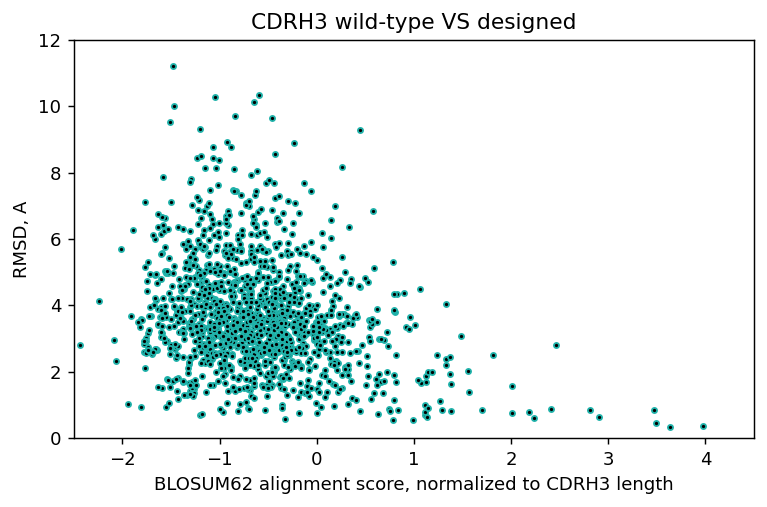

In [119]:
#general distribution of RMSD against normalized BLOSUM62 score for CDRH3
plt.figure(dpi=130)

plt.scatter(
    x=for_eda["cdrh3_blosum62_scores_mean_norm"],
    y=for_eda["rmsd_h"],
    s=8,
    c="black",
    edgecolors="lightseagreen",
    linewidths=1
)

plt.title("CDRH3 wild-type VS designed")
plt.xlabel("BLOSUM62 alignment score, normalized to CDRH3 length")
plt.ylabel("RMSD, A")
plt.xlim((-2.5, 4.5))
plt.ylim((0, 12))

plt.tight_layout()
plt.savefig("global_vis/cdrh3.png", dpi=300, facecolor="white")

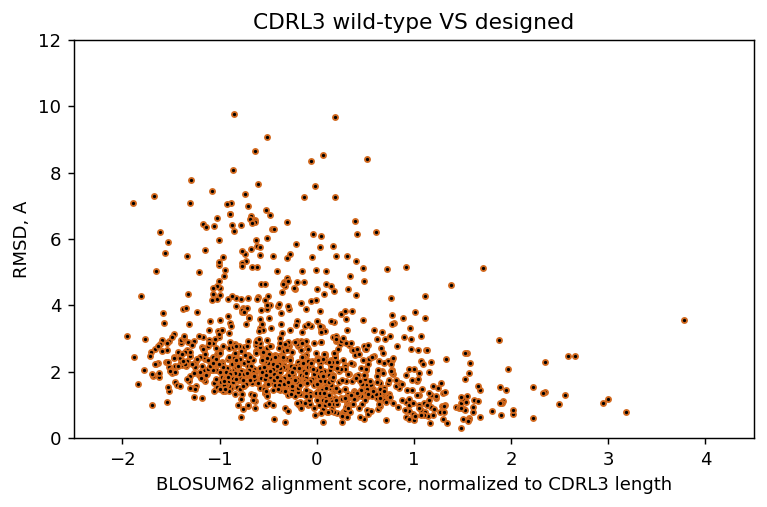

In [120]:
#general distribution of RMSD against normalized BLOSUM62 score for CDRL3
plt.figure(dpi=130)

plt.scatter(
    x=for_eda["cdrl3_blosum62_scores_mean_norm"],
    y=for_eda["rmsd_l"],
    s=8,
    c="black",
    edgecolors="chocolate",
    linewidths=1
)

plt.title("CDRL3 wild-type VS designed")
plt.xlabel("BLOSUM62 alignment score, normalized to CDRL3 length")
plt.ylabel("RMSD, A")
plt.xlim((-2.5, 4.5))
plt.ylim((0, 12))

plt.tight_layout()
plt.savefig("global_vis/cdrl3.png", dpi=300, facecolor="white")

### Clustered by pdb_id visualization ###

In [121]:
#subdirectory for clustered by pdb_id visualization pictures
os.makedirs("pdb_id_vis", exist_ok=True)

#### Total view ####

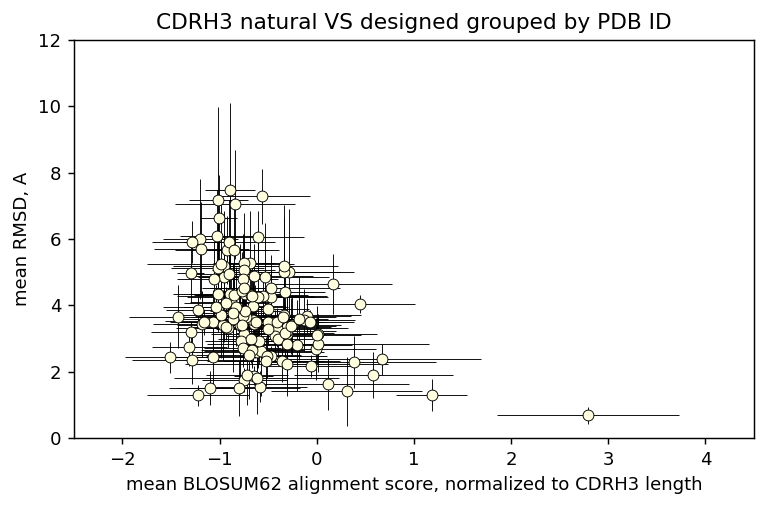

In [19]:
#let's take a look on errorbar where each point represents designs for 1 pdb_id
#point coords = mean, error whiskers = standard deviation

#errorbar for CDRH3
plt.figure(dpi=130)

plt.errorbar(
    x=for_eda.groupby("pdb_id")["cdrh3_blosum62_scores_mean_norm"].mean(),
    y=for_eda.groupby("pdb_id")["rmsd_h"].mean(),
    xerr=for_eda.groupby("pdb_id")["cdrh3_blosum62_scores_mean_norm"].std(),
    yerr=for_eda.groupby("pdb_id")["rmsd_h"].std(),
    fmt="o",
    ecolor="black",
    elinewidth=0.5,
    markeredgecolor="black",
    markeredgewidth=0.5,
    markerfacecolor="lightyellow",
    markersize=6
)

plt.title("CDRH3 natural VS designed grouped by PDB ID")
plt.xlabel("mean BLOSUM62 alignment score, normalized to CDRH3 length")
plt.ylabel("mean RMSD, A")
plt.xlim((-2.5, 4.5))
plt.ylim((0, 12))

plt.tight_layout()
plt.savefig("pdb_id_vis/cdrh3.png", dpi=300, facecolor="white")

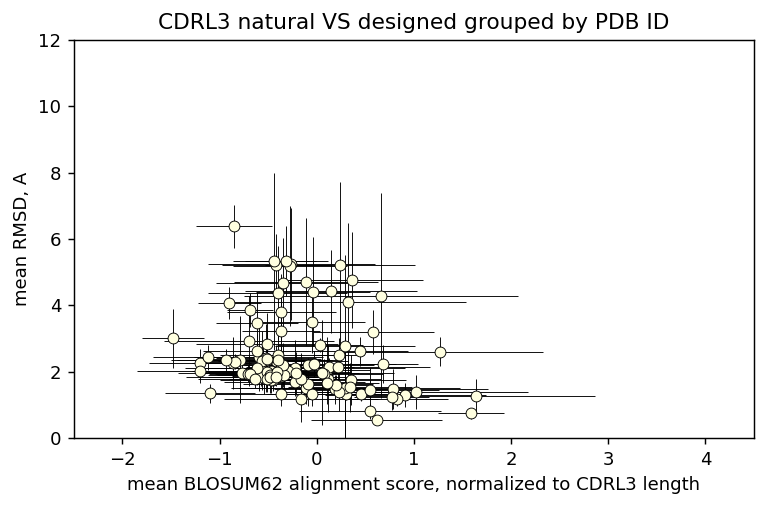

In [20]:
#errorbar for CDRL3
plt.figure(dpi=130)

plt.errorbar(
    x=for_eda.groupby("pdb_id")["cdrl3_blosum62_scores_mean_norm"].mean(),
    y=for_eda.groupby("pdb_id")["rmsd_l"].mean(),
    xerr=for_eda.groupby("pdb_id")["cdrl3_blosum62_scores_mean_norm"].std(),
    yerr=for_eda.groupby("pdb_id")["rmsd_l"].std(),
    fmt="o",
    ecolor="black",
    elinewidth=0.5,
    markeredgecolor="black",
    markeredgewidth=0.5,
    markerfacecolor="lightyellow",
    markersize=6
)

plt.title("CDRL3 natural VS designed grouped by PDB ID")
plt.xlabel("mean BLOSUM62 alignment score, normalized to CDRL3 length")
plt.ylabel("mean RMSD, A")
plt.xlim((-2.5, 4.5))
plt.ylim((0, 12))

plt.tight_layout()
plt.savefig("pdb_id_vis/cdrl3.png", dpi=300, facecolor="white")

#### Length dependency ####

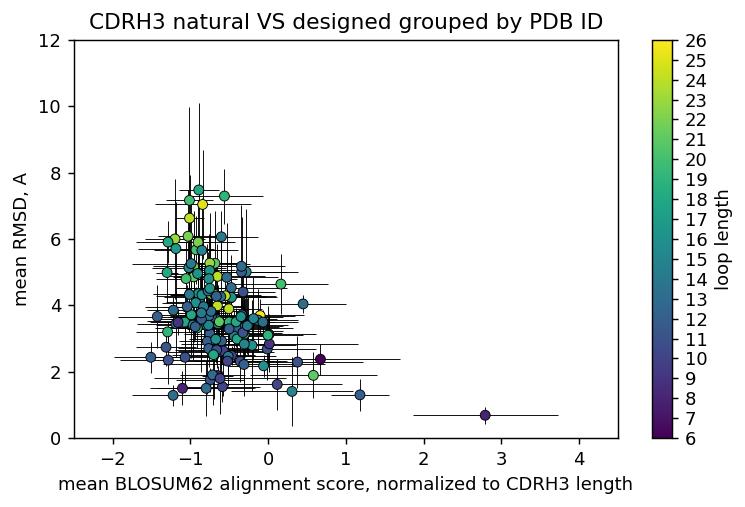

In [65]:
#the most obvious parameter could influence the quality of our redisctions is CDR length
#let's introduce it to our errorbar for CDRH3
plt.figure(dpi=130)

plt.errorbar(
    x=for_eda.groupby("pdb_id")["cdrh3_blosum62_scores_mean_norm"].mean(),
    y=for_eda.groupby("pdb_id")["rmsd_h"].mean(),
    xerr=for_eda.groupby("pdb_id")["cdrh3_blosum62_scores_mean_norm"].std(),
    yerr=for_eda.groupby("pdb_id")["rmsd_h"].std(),
    fmt="o",
    ecolor="black",
    elinewidth=0.5,
    markeredgecolor="black",
    markeredgewidth=0.5,
    markerfacecolor="lightyellow",
    markersize=0,
    zorder=1
)

lengths = np.array(for_eda.groupby("pdb_id")["cdrh3_stop_orig"].mean()) \
    - np.array(for_eda.groupby("pdb_id")["cdrh3_start_orig"].mean()) \
    + np.ones(len(for_eda["pdb_id"].unique()))

plt.scatter(
    x=for_eda.groupby("pdb_id")["cdrh3_blosum62_scores_mean_norm"].mean(),
    y=for_eda.groupby("pdb_id")["rmsd_h"].mean(),
    c=lengths,
    s=30,
    edgecolors="black",
    linewidths=0.5,
    zorder=2
)

plt.title("CDRH3 natural VS designed grouped by PDB ID")
plt.xlabel("mean BLOSUM62 alignment score, normalized to CDRH3 length")
plt.ylabel("mean RMSD, A")
plt.xlim((-2.5, 4.5))
plt.ylim((0, 12))

plt.set_cmap('viridis')

#we want discrete ticks here
cbar = plt.colorbar(
    ticks=np.arange(
        min(lengths),
        max(lengths) + 1
    )
)
cbar.set_label("loop length")

plt.tight_layout()
plt.savefig("pdb_id_vis/cdrh3_length.png", dpi=300, facecolor="white")

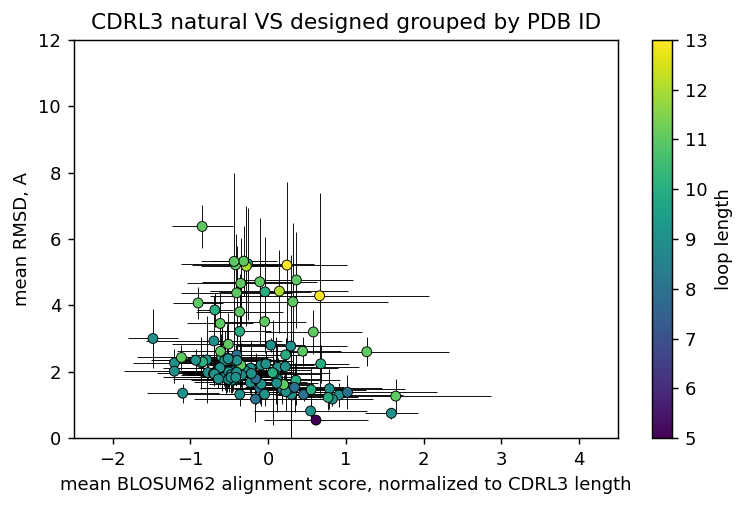

In [66]:
#...and CDRL3
#let's introduce it to our errorbar for CDRH3
plt.figure(dpi=130)

plt.errorbar(
    x=for_eda.groupby("pdb_id")["cdrl3_blosum62_scores_mean_norm"].mean(),
    y=for_eda.groupby("pdb_id")["rmsd_l"].mean(),
    xerr=for_eda.groupby("pdb_id")["cdrl3_blosum62_scores_mean_norm"].std(),
    yerr=for_eda.groupby("pdb_id")["rmsd_l"].std(),
    fmt="o",
    ecolor="black",
    elinewidth=0.5,
    markeredgecolor="black",
    markeredgewidth=0.5,
    markerfacecolor="lightyellow",
    markersize=0,
    zorder=1
)

lengths = np.array(for_eda.groupby("pdb_id")["cdrl3_stop_orig"].mean()) \
    - np.array(for_eda.groupby("pdb_id")["cdrl3_start_orig"].mean()) \
    + np.ones(len(for_eda["pdb_id"].unique()))

plt.scatter(
    x=for_eda.groupby("pdb_id")["cdrl3_blosum62_scores_mean_norm"].mean(),
    y=for_eda.groupby("pdb_id")["rmsd_l"].mean(),
    c=lengths,
    s=30,
    edgecolors="black",
    linewidths=0.5,
    zorder=2
)

plt.title("CDRL3 natural VS designed grouped by PDB ID")
plt.xlabel("mean BLOSUM62 alignment score, normalized to CDRL3 length")
plt.ylabel("mean RMSD, A")
plt.xlim((-2.5, 4.5))
plt.ylim((0, 12))

plt.set_cmap('viridis')

cbar = plt.colorbar(
    ticks=np.arange(
        min(lengths),
        max(lengths) + 1
    )
)
cbar.set_label("loop length")

plt.tight_layout()
plt.savefig("pdb_id_vis/cdrl3_length.png", dpi=300, facecolor="white")

#### Hydrophobicity dependency ####

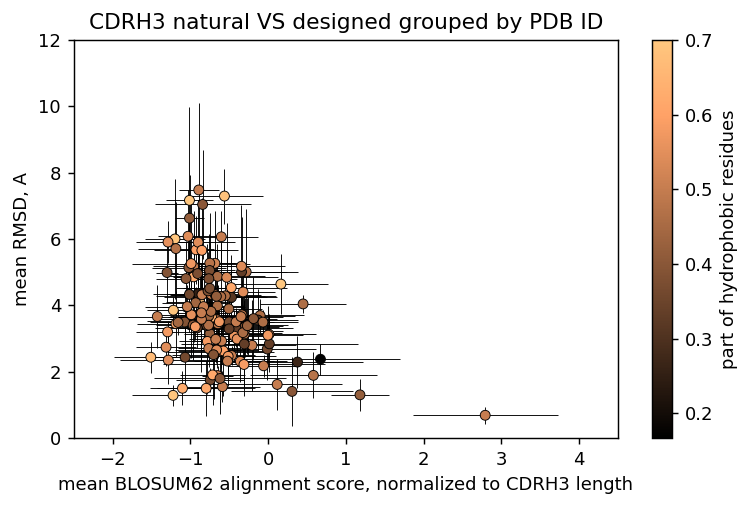

In [63]:
#less obvious, but very common parameter is hydrophobicity
#there are many hydrophobicity scales, we will use simply the part of hydrophobic aminoacids
hydrophobic = ["A", "F", "I", "L", "M", "P", "V", "W", "Y"]

plt.figure(dpi=130)

plt.errorbar(
    x=for_eda.groupby("pdb_id")["cdrh3_blosum62_scores_mean_norm"].mean(),
    y=for_eda.groupby("pdb_id")["rmsd_h"].mean(),
    xerr=for_eda.groupby("pdb_id")["cdrh3_blosum62_scores_mean_norm"].std(),
    yerr=for_eda.groupby("pdb_id")["rmsd_h"].std(),
    fmt="o",
    ecolor="black",
    elinewidth=0.5,
    markeredgecolor="black",
    markeredgewidth=0.5,
    markerfacecolor="lightyellow",
    markersize=0,
    zorder=1
)


plt.scatter(
    x=for_eda.groupby("pdb_id")["cdrh3_blosum62_scores_mean_norm"].mean(),
    y=for_eda.groupby("pdb_id")["rmsd_h"].mean(),
    c=np.array(
        for_eda.groupby("pdb_id")["cdrh3_seq"].nth(0).apply(
            lambda s : sum(
                s.count(char) for char in hydrophobic
            ) / len(s)
        )
    ),
    s=30,
    edgecolors="black",
    linewidths=0.5,
    zorder=2
)

plt.title("CDRH3 natural VS designed grouped by PDB ID")
plt.xlabel("mean BLOSUM62 alignment score, normalized to CDRH3 length")
plt.ylabel("mean RMSD, A")
plt.xlim((-2.5, 4.5))
plt.ylim((0, 12))

plt.set_cmap('copper')

cbar = plt.colorbar()
cbar.set_label("part of hydrophobic residues")

plt.tight_layout()
plt.savefig("pdb_id_vis/cdrh3_hydrophobicity.png", dpi=300, facecolor="white")

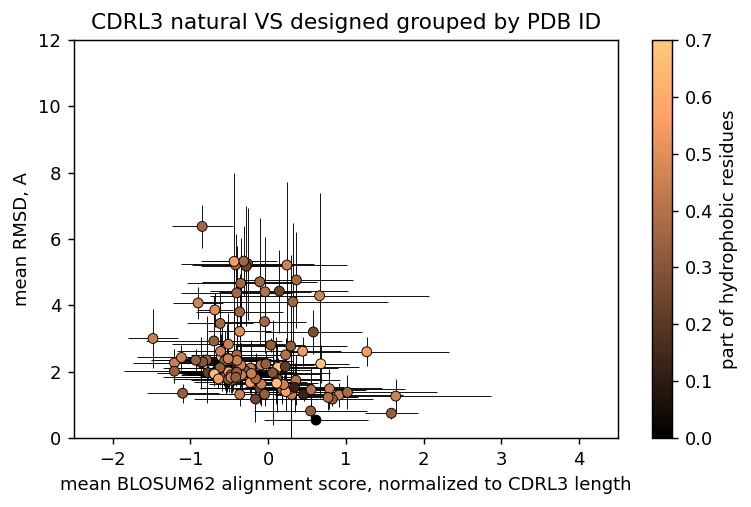

In [69]:
#for CDRL3
hydrophobic = ["A", "F", "I", "L", "M", "P", "V", "W", "Y"]

plt.figure(dpi=130)

plt.errorbar(
    x=for_eda.groupby("pdb_id")["cdrl3_blosum62_scores_mean_norm"].mean(),
    y=for_eda.groupby("pdb_id")["rmsd_l"].mean(),
    xerr=for_eda.groupby("pdb_id")["cdrl3_blosum62_scores_mean_norm"].std(),
    yerr=for_eda.groupby("pdb_id")["rmsd_l"].std(),
    fmt="o",
    ecolor="black",
    elinewidth=0.5,
    markeredgecolor="black",
    markeredgewidth=0.5,
    markerfacecolor="lightyellow",
    markersize=0,
    zorder=1
)


plt.scatter(
    x=for_eda.groupby("pdb_id")["cdrl3_blosum62_scores_mean_norm"].mean(),
    y=for_eda.groupby("pdb_id")["rmsd_l"].mean(),
    c=np.array(
        for_eda.groupby("pdb_id")["cdrl3_seq"].nth(0).apply(
            lambda s : sum(
                s.count(char) for char in hydrophobic
            ) / len(s) if len(s) > 0 else None
        )
    ),
    s=30,
    edgecolors="black",
    linewidths=0.5,
    zorder=2
)

plt.title("CDRL3 natural VS designed grouped by PDB ID")
plt.xlabel("mean BLOSUM62 alignment score, normalized to CDRL3 length")
plt.ylabel("mean RMSD, A")
plt.xlim((-2.5, 4.5))
plt.ylim((0, 12))

plt.set_cmap('copper')

cbar = plt.colorbar()
cbar.set_label("part of hydrophobic residues")

plt.tight_layout()
plt.savefig("pdb_id_vis/cdrl3_hydrophobicity.png", dpi=300, facecolor="white")

#### Prolines number dependency ####

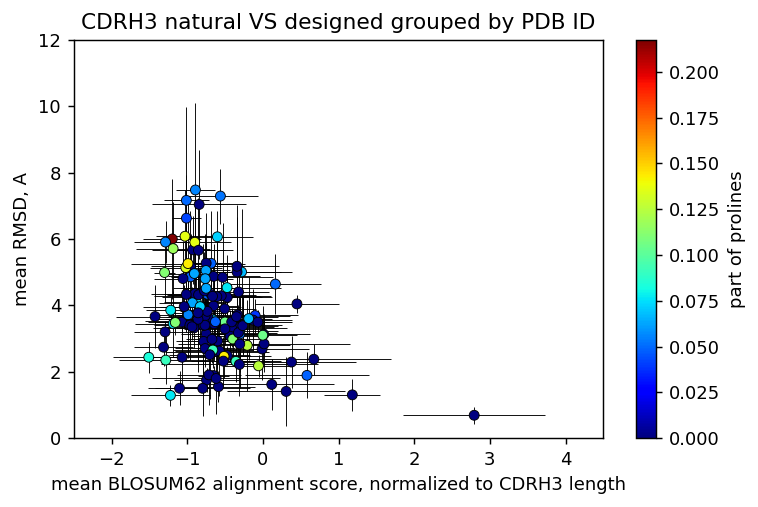

In [75]:
#maybe relative prolines number in wild-type loop impacts?
plt.figure(dpi=130)

plt.errorbar(
    x=for_eda.groupby("pdb_id")["cdrh3_blosum62_scores_mean_norm"].mean(),
    y=for_eda.groupby("pdb_id")["rmsd_h"].mean(),
    xerr=for_eda.groupby("pdb_id")["cdrh3_blosum62_scores_mean_norm"].std(),
    yerr=for_eda.groupby("pdb_id")["rmsd_h"].std(),
    fmt="o",
    ecolor="black",
    elinewidth=0.5,
    markeredgecolor="black",
    markeredgewidth=0.5,
    markerfacecolor="lightyellow",
    markersize=0,
    zorder=1
)


plt.scatter(
    x=for_eda.groupby("pdb_id")["cdrh3_blosum62_scores_mean_norm"].mean(),
    y=for_eda.groupby("pdb_id")["rmsd_h"].mean(),
    c=np.array(
        for_eda.groupby("pdb_id")["cdrh3_seq"].nth(0).apply(
            lambda s : s.count("P") / len(s)
        )
    ),
    s=30,
    edgecolors="black",
    linewidths=0.5,
    zorder=2
)

plt.title("CDRH3 natural VS designed grouped by PDB ID")
plt.xlabel("mean BLOSUM62 alignment score, normalized to CDRH3 length")
plt.ylabel("mean RMSD, A")
plt.xlim((-2.5, 4.5))
plt.ylim((0, 12))

plt.set_cmap('jet')

cbar = plt.colorbar()
cbar.set_label("part of prolines")

plt.tight_layout()
plt.savefig("pdb_id_vis/cdrh3_prolines.png", dpi=300, facecolor="white")

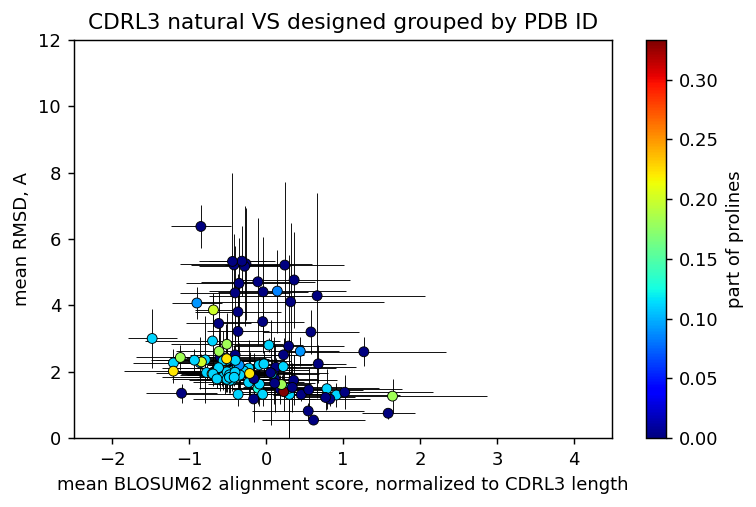

In [78]:
#for CDRL3
plt.figure(dpi=130)

plt.errorbar(
    x=for_eda.groupby("pdb_id")["cdrl3_blosum62_scores_mean_norm"].mean(),
    y=for_eda.groupby("pdb_id")["rmsd_l"].mean(),
    xerr=for_eda.groupby("pdb_id")["cdrl3_blosum62_scores_mean_norm"].std(),
    yerr=for_eda.groupby("pdb_id")["rmsd_l"].std(),
    fmt="o",
    ecolor="black",
    elinewidth=0.5,
    markeredgecolor="black",
    markeredgewidth=0.5,
    markerfacecolor="lightyellow",
    markersize=0,
    zorder=1
)


plt.scatter(
    x=for_eda.groupby("pdb_id")["cdrl3_blosum62_scores_mean_norm"].mean(),
    y=for_eda.groupby("pdb_id")["rmsd_l"].mean(),
    c=np.array(
        for_eda.groupby("pdb_id")["cdrl3_seq"].nth(0).apply(
            lambda s : s.count("P") / len(s) if len(s) > 0 else None
        )
    ),
    s=30,
    edgecolors="black",
    linewidths=0.5,
    zorder=2
)

plt.title("CDRL3 natural VS designed grouped by PDB ID")
plt.xlabel("mean BLOSUM62 alignment score, normalized to CDRL3 length")
plt.ylabel("mean RMSD, A")
plt.xlim((-2.5, 4.5))
plt.ylim((0, 12))

plt.set_cmap('jet')

cbar = plt.colorbar()
cbar.set_label("part of prolines")

plt.tight_layout()
plt.savefig("pdb_id_vis/cdrl3_prolines.png", dpi=300, facecolor="white")

#### Marginals highlighting ####

In [11]:
#let's point out pdb_ids with the smallest mean RMSD, the biggest mean RMSD, the smallest and the biggest dispersion over RMSD to look on them in PyMOL

#pairs <pdb_id : mean RMSD> for CDRH3
mean_rmsd_pairs_cdrh3 = sorted(
    dict(
        for_eda.groupby("pdb_id")["rmsd_h"].mean()
    ).items(),
    key=lambda pair : pair[1]
)

#pairs <pdb_id : RMSD standard deviation> for CDRH3
std_rmsd_pairs_cdrh3 = sorted(
    dict(
        for_eda.groupby("pdb_id")["rmsd_h"].std()
    ).items(),
    key=lambda pair : pair[1]
)

#pdb_id with extreme values of mean RMSD of CDRH3
cdrh3_biggest_mean_rmsd = mean_rmsd_pairs_cdrh3[-1][0]
cdrh3_smallest_mean_rmsd = mean_rmsd_pairs_cdrh3[0][0]

#pdb_id with extreme values of RMSD standard deviation of CDRH3
cdrh3_biggest_std_rmsd = std_rmsd_pairs_cdrh3[-1][0]
cdrh3_smallest_std_rmsd = std_rmsd_pairs_cdrh3[0][0]


#the same stuff for CDRL3
mean_rmsd_pairs_cdrl3 = sorted(
    dict(
        for_eda[~for_eda["rmsd_l"].isna()].groupby("pdb_id")["rmsd_l"].mean()
    ).items(),
    key=lambda pair : pair[1]
)

#pairs <pdb_id : RMSD standard deviation> for CDRH3
std_rmsd_pairs_cdrl3 = sorted(
    dict(
        for_eda[~for_eda["rmsd_l"].isna()].groupby("pdb_id")["rmsd_l"].std()
    ).items(),
    key=lambda pair : pair[1]
)

#pdb_id with extreme values of mean RMSD of CDRH3
cdrl3_biggest_mean_rmsd = mean_rmsd_pairs_cdrl3[-1][0]
cdrl3_smallest_mean_rmsd = mean_rmsd_pairs_cdrl3[0][0]

#pdb_id with extreme values of RMSD standard deviation of CDRH3
cdrl3_biggest_std_rmsd = std_rmsd_pairs_cdrl3[-1][0]
cdrl3_smallest_std_rmsd = std_rmsd_pairs_cdrl3[0][0]

In [48]:
#let's highlight them on errorbar with RMSD - BLOSUM62 score distribution

def errorbar_by_pdb_id(pdb_id, color, cdr):
    '''
    pdb_id : str, pdb_id to representate on the errorbar
    color : str, color for the marker
    cdr : str, "cdrh3" or "cdrl3"
    return : mpatches.Patch for the legend
    '''
    plt.errorbar(
        x=for_eda[for_eda["pdb_id"] == pdb_id].groupby("pdb_id")[f"{cdr}_blosum62_scores_mean_norm"].mean(),
        y=for_eda[for_eda["pdb_id"] == pdb_id].groupby("pdb_id")[f"rmsd_{cdr[3]}"].mean(),
        xerr=for_eda[for_eda["pdb_id"] == pdb_id].groupby("pdb_id")[f"{cdr}_blosum62_scores_mean_norm"].std(),
        yerr=for_eda[for_eda["pdb_id"] == pdb_id].groupby("pdb_id")[f"rmsd_{cdr[3]}"].std(),
        fmt="o",
        ecolor="black",
        elinewidth=0.5,
        markeredgecolor="black",
        markeredgewidth=0.5,
        markerfacecolor=color,
        markersize=6
    )
    
    return mpatches.Patch(color=color, label=pdb_id)

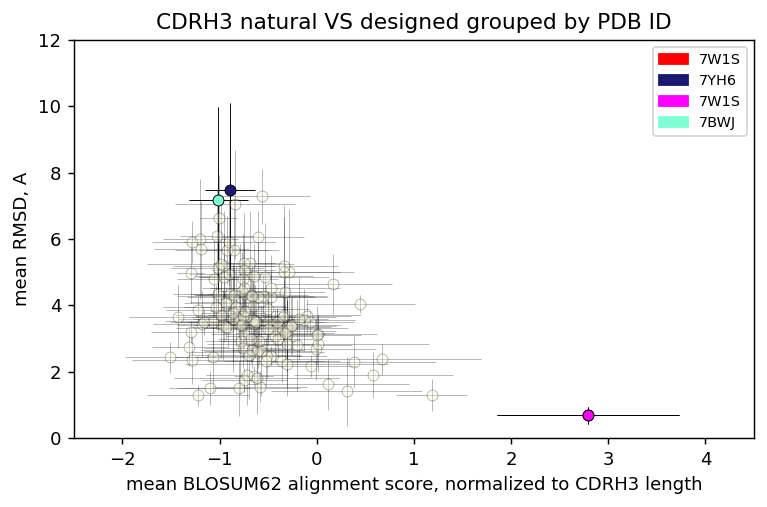

In [50]:
#CDRH3
plt.figure(dpi=130)

#transparent errorbar with all pdb_ids
plt.errorbar(
    x=for_eda.groupby("pdb_id")["cdrh3_blosum62_scores_mean_norm"].mean(),
    y=for_eda.groupby("pdb_id")["rmsd_h"].mean(),
    xerr=for_eda.groupby("pdb_id")["cdrh3_blosum62_scores_mean_norm"].std(),
    yerr=for_eda.groupby("pdb_id")["rmsd_h"].std(),
    fmt="o",
    ecolor="black",
    elinewidth=0.5,
    markeredgecolor="black",
    markeredgewidth=0.5,
    markerfacecolor="lightyellow",
    markersize=6,
    alpha=0.3
)

#matplotlib patches for the legend
patches = []

#the smallest mean RMSD
patches.append(
    errorbar_by_pdb_id(
        pdb_id=cdrh3_smallest_mean_rmsd, 
        color="red",
        cdr="cdrh3"
    )
)

#the biggest mean RMSD
patches.append(
    errorbar_by_pdb_id(
        pdb_id=cdrh3_biggest_mean_rmsd, 
        color="midnightblue",
        cdr="cdrh3"
    )
)

#the smallest RMSD standard deviation
patches.append(
    errorbar_by_pdb_id(
        pdb_id=cdrh3_smallest_std_rmsd, 
        color="magenta",
        cdr="cdrh3"
    )
)

#the biggest RMSD standard deviation
patches.append(
    errorbar_by_pdb_id(
        pdb_id=cdrh3_biggest_std_rmsd, 
        color="aquamarine",
        cdr="cdrh3"
    )
)

plt.legend(
    handles=patches,
    fontsize = 8
)

plt.title("CDRH3 natural VS designed grouped by PDB ID")
plt.xlabel("mean BLOSUM62 alignment score, normalized to CDRH3 length")
plt.ylabel("mean RMSD, A")
plt.xlim((-2.5, 4.5))
plt.ylim((0, 12))

plt.tight_layout()
plt.savefig("pdb_id_vis/cdrh3_marginals.png", dpi=300, facecolor="white")

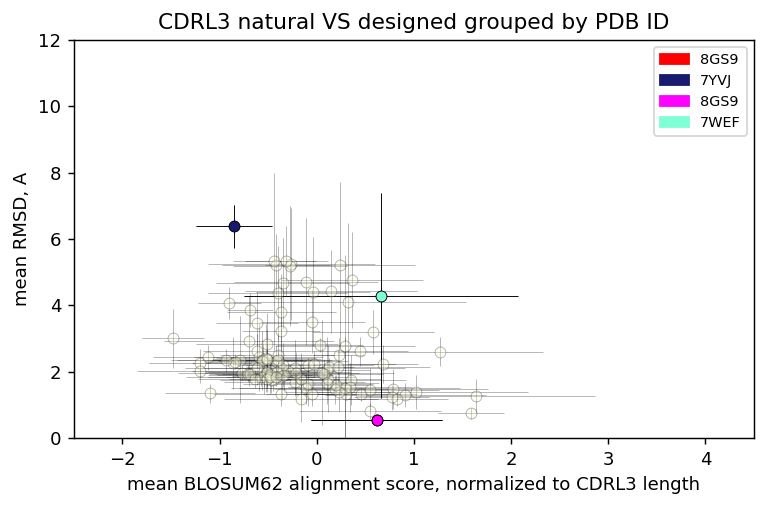

In [51]:
#CDRL3
plt.figure(dpi=130)

#transparent errorbar with all pdb_ids
plt.errorbar(
    x=for_eda.groupby("pdb_id")["cdrl3_blosum62_scores_mean_norm"].mean(),
    y=for_eda.groupby("pdb_id")["rmsd_l"].mean(),
    xerr=for_eda.groupby("pdb_id")["cdrl3_blosum62_scores_mean_norm"].std(),
    yerr=for_eda.groupby("pdb_id")["rmsd_l"].std(),
    fmt="o",
    ecolor="black",
    elinewidth=0.5,
    markeredgecolor="black",
    markeredgewidth=0.5,
    markerfacecolor="lightyellow",
    markersize=6,
    alpha=0.3
)

#matplotlib patches for the legend
patches = []

#the smallest mean RMSD
patches.append(
    errorbar_by_pdb_id(
        pdb_id=cdrl3_smallest_mean_rmsd, 
        color="red",
        cdr="cdrl3"
    )
)

#the biggest mean RMSD
patches.append(
    errorbar_by_pdb_id(
        pdb_id=cdrl3_biggest_mean_rmsd, 
        color="midnightblue",
        cdr="cdrl3"
    )
)

#the smallest RMSD standard deviation
patches.append(
    errorbar_by_pdb_id(
        pdb_id=cdrl3_smallest_std_rmsd, 
        color="magenta",
        cdr="cdrl3"
    )
)

#the biggest RMSD standard deviation
patches.append(
    errorbar_by_pdb_id(
        pdb_id=cdrl3_biggest_std_rmsd, 
        color="aquamarine",
        cdr="cdrl3"
    )
)

plt.legend(
    handles=patches,
    fontsize = 8
)

plt.title("CDRL3 natural VS designed grouped by PDB ID")
plt.xlabel("mean BLOSUM62 alignment score, normalized to CDRL3 length")
plt.ylabel("mean RMSD, A")
plt.xlim((-2.5, 4.5))
plt.ylim((0, 12))

plt.tight_layout()
plt.savefig("pdb_id_vis/cdrl3_marginals.png", dpi=300, facecolor="white")

### PyMOL visualization ###

In [5]:
#subdirectory for PyMOL visualization
os.makedirs("pymol_vis", exist_ok=True)

In [44]:
def visualize_alignment(pdb_id, mode, analyzed_data):
    '''
    pdb_id : pdb_id of the protein we want to visualize
    mode : "cdrh3" or "cdrl3"
    analyzed_data : pd.DataFrame with info about designs

    assume we have opened PyMOL session
    this function will re-init it!!!
    saves .pse session file with aligned WT structure and designed structures, .png with some view (but probably not the optimal)
    '''
    
    #re-init our PyMOL session
    cmd.reinitialize()

    #first, let's load and color WT protein
    cmd.load(f"structures_splitted/{list(analyzed_data[analyzed_data['pdb_id'] == pdb_id]['index'])[0]}_complex.pdb")
    cmd.remove("hetatm")
    cmd.color(
        "aquamarine",
        f"{list(analyzed_data[analyzed_data['pdb_id'] == pdb_id]['index'])[0]}_complex and name C*"
    )

    #then load, color designed proteins and superpose them to WT protein
    for rfdiffusion_launch_num in range(10):
        cmd.load(f"rfdiffusion_launch/{list(analyzed_data[analyzed_data['pdb_id'] == pdb_id]['index'])[0]}_{rfdiffusion_launch_num}.pdb")
        cmd.color(
            "purple",
            f'''{list(analyzed_data[analyzed_data['pdb_id'] == pdb_id]['index'])[0]}_{rfdiffusion_launch_num} and name C*'''
        )
        cmd.align(
            f"{list(analyzed_data[analyzed_data['pdb_id'] == pdb_id]['index'])[0]}_{rfdiffusion_launch_num}", 
            f"{list(analyzed_data[analyzed_data['pdb_id'] == pdb_id]['index'])[0]}_complex"
        )

    #get adequate camera position
    cmd.orient("all")

    #make all proteins transparent
    cmd.do('''
        set \
           cartoon_transparency, \
           0.8, \
           (all)
    ''')

    #zoom camera on WT loop
    cmd.do(f'''
        zoom ({list(analyzed_data[analyzed_data['pdb_id'] == pdb_id]['index'])[0]}_complex \
            and chain {list(analyzed_data[analyzed_data['pdb_id'] == pdb_id]["vl" if mode == "cdrl3" else "vh"])[0]} \
            and resi {
                list(analyzed_data[analyzed_data['pdb_id'] == pdb_id][f"{mode}_start_orig"])[0]
            }-{
                list(analyzed_data[analyzed_data['pdb_id'] == pdb_id][f"{mode}_stop_orig"])[0]
            }), \ 
            15
    ''')

    #highlight WT loop by removing its transparency
    cmd.do(f'''
        set cartoon_transparency, \
        0, \
        ({list(analyzed_data[analyzed_data['pdb_id'] == pdb_id]['index'])[0]}_complex \
            and chain {list(analyzed_data[analyzed_data['pdb_id'] == pdb_id]["vl" if mode == "cdrl3" else "vh"])[0]} \
            and resi {
                list(analyzed_data[analyzed_data['pdb_id'] == pdb_id][f"{mode}_start_orig"])[0]
            }-{
                list(analyzed_data[analyzed_data['pdb_id'] == pdb_id][f"{mode}_stop_orig"])[0]
            })
    ''')

    #highlight designed loops
    for rfdiffusion_launch_num in range(10):
        cmd.do(f'''
            set cartoon_transparency, \
            0, \
            ({list(analyzed_data[analyzed_data['pdb_id'] == pdb_id]['index'])[0]}_{rfdiffusion_launch_num} \
            and chain A \
            and resi {
                list(analyzed_data[analyzed_data['pdb_id'] == pdb_id][f"{mode}_designed_start"])[0]
            }-{
                list(analyzed_data[analyzed_data['pdb_id'] == pdb_id][f"{mode}_designed_stop"])[0]
            })
        ''')

    #some visualization stuff
    cmd.do('''
        bg white
        set light_count, 8
        set spec_count, 1
        set shininess, 10
        set specular, 0
        set direct, 0.5
        set ambient, 1
        set reflect, 0
        set ray_trace_mode, 3
    ''')

    #let's take a look on WT loop's sidechains
    cmd.show(
        "sticks",
        f'''({list(analyzed_data[analyzed_data['pdb_id'] == pdb_id]['index'])[0]}_complex \
            and chain {list(analyzed_data[analyzed_data['pdb_id'] == pdb_id]["vl" if mode == "cdrl3" else "vh"])[0]} \
            and resi {
                list(analyzed_data[analyzed_data['pdb_id'] == pdb_id][f"{mode}_start_orig"])[0]
            }-{
                list(analyzed_data[analyzed_data['pdb_id'] == pdb_id][f"{mode}_stop_orig"])[0]
            })'''
    )

    #not to show backbone sticks, they make the image overloaded
    cmd.set(
        "cartoon_side_chain_helper",
        1
    )

    #thick sticks look fancy
    cmd.set(
        "stick_radius",
        0.42
    )

    #save session to .pse file
    #later we can open them in PyMOL and analyze or make pictures from different camera angles
    cmd.save(f"pymol_vis/{mode}_{pdb_id}_aligned.pse")

    #delete aligned parts of designed molecules bcs they superpose to the same parts of WT protein but require 10x more computations for rendering
    cmd.remove(f'''{list(analyzed_data[analyzed_data['pdb_id'] == pdb_id]['index'])[0]}_* \
        and not {list(analyzed_data[analyzed_data['pdb_id'] == pdb_id]['index'])[0]}_complex \
        and not (resi {
            list(analyzed_data[analyzed_data['pdb_id'] == pdb_id][f"{mode}_designed_start"])[0]
        }-{
            list(analyzed_data[analyzed_data['pdb_id'] == pdb_id][f"{mode}_designed_stop"])[0]
        } \
        and chain A)''')
            
    #delete hydrogens just to make pictures more laconic
    cmd.hide(
        "everything", 
        "name H*"
    )

    #save .png from default camera angle
    cmd.png(f"pymol_vis/{mode}_{pdb_id}_aligned.png", 2000, 2000, ray=1)

In [45]:
visualize_alignment(
    pdb_id=cdrh3_biggest_mean_rmsd, 
    mode="cdrh3", 
    analyzed_data=analyzed_data
)
visualize_alignment(
    pdb_id=cdrh3_smallest_mean_rmsd, 
    mode="cdrh3", 
    analyzed_data=analyzed_data
)
visualize_alignment(
    pdb_id=cdrh3_biggest_std_rmsd, 
    mode="cdrh3", 
    analyzed_data=analyzed_data
)

visualize_alignment(
    pdb_id=cdrl3_biggest_mean_rmsd, 
    mode="cdrl3", 
    analyzed_data=analyzed_data
)
visualize_alignment(
    pdb_id=cdrl3_smallest_mean_rmsd, 
    mode="cdrl3", 
    analyzed_data=analyzed_data
)
visualize_alignment(
    pdb_id=cdrl3_biggest_std_rmsd, 
    mode="cdrl3", 
    analyzed_data=analyzed_data
)

PyMOL>        set            cartoon_transparency,            0.8,            (all)
 Setting: cartoon_transparency set for 1997 atoms in object "910_complex".
 Setting: cartoon_transparency set for 1048 atoms in object "910_0".
 Setting: cartoon_transparency set for 1048 atoms in object "910_1".
 Setting: cartoon_transparency set for 1048 atoms in object "910_2".
 Setting: cartoon_transparency set for 1048 atoms in object "910_3".
 Setting: cartoon_transparency set for 1048 atoms in object "910_4".
 Setting: cartoon_transparency set for 1048 atoms in object "910_5".
 Setting: cartoon_transparency set for 1048 atoms in object "910_6".
 Setting: cartoon_transparency set for 1048 atoms in object "910_7".
 Setting: cartoon_transparency set for 1048 atoms in object "910_8".
 Setting: cartoon_transparency set for 1048 atoms in object "910_9".
PyMOL>    
PyMOL>        zoom (910_complex             and chain H             and resi 97-114), \ 
PyMOL>            15
PyMOL>    
PyMOL>        set c